# Experiment 02


The current approach for creating train, validation and test data sets is to split 
the data in long-format, i.e. one observation is an intensity value from one sample representing one peptide, into the desired splits. In this process missing values are not regarded.

- [x] mask entries in larger dataset in long-format
- [x] mask peptides based on their frequency in samples (probability of being observed)
- [x] create *long-format* training data set without masked values for each model
    - FNN based on embeddings of peptides and samples (long-format **without** missing values)
    - Denoising AE (wide-format **with** missing values)
    - VAE (wide-format **with** missing values)
- [ ] restrict to only a training data split of consective data: Increase number of samples.
    - focus on best reconstruction performance
    - mean comparison

### Collaborative Filtering model

- Cannot accomodate iid assumption of statistical test in current setup for embedding vectors.
  - if pretrained model should be applied to an new batch of replicates (with a certain condition) one would need to find a way to initialize the sample embeddings without fine-tuning the model

In [1]:
import logging
from pprint import pprint
import seaborn
import numpy.testing as npt  # fastcore.test functionality

from pathlib import Path


import vaep.io_images
from vaep.pandas import interpolate
from vaep.model import build_df_from_pred_batches

from src.nb_imports import *
from src import metadata
from src.logging import setup_logger

logger = setup_logger(logger=logging.getLogger('vaep'))
logger.info("Experiment 02")

figures = {}  # collection of ax or figures

FOLDER_MQ_TXT_DATA = data\mq_out
vaep - INFO     Experiment 02


In [2]:
# None takes all
N_SAMPLES: int = 1000
n_features: int = 50
ADD_TENSORBOARD: bool = False
FN_PEPTIDE_INTENSITIES: Path = (
    config.FOLDER_DATA / 'df_intensities_N07285_M01000')  # 90%
epochs_max = 10
batch_size = 32
latent_dim = 2
most_common: bool = False
most_uncommon: bool = False
out_folder: str = 'poster'
# write to read only config ? namedtuple?

In [3]:
# Parameters
n_feat = 500
n_epochs = 30
out_folder = "runs/2D"


In [4]:
BATCH_SIZE, EPOCHS = batch_size, epochs_max
folder = Path(out_folder) / f'feat_{n_features:04d}_epochs_{epochs_max:03d}'
print(f"{folder = }")

if most_common and most_uncommon:
    raise ValueError(f"Cannot be both True: {most_common = } and {most_uncommon = }")

folder = Path('runs/2D/feat_0050_epochs_010')


## Raw data

In [5]:
FN_PEPTIDE_INTENSITIES = Path(FN_PEPTIDE_INTENSITIES)

In [6]:
analysis = AnalyzePeptides(fname=FN_PEPTIDE_INTENSITIES, nrows=None)
analysis.df.columns.name = 'peptide'
analysis.log_transform(np.log2)
analysis

AnalyzePeptides with attributes: M, N, df, index_col, is_log_transformed, is_wide_format, log_fct, stats

In [7]:
# some date are not possible in the indices
rename_indices_w_wrong_dates = {'20161131_LUMOS1_nLC13_AH_MNT_HeLa_long_03': '20161130_LUMOS1_nLC13_AH_MNT_HeLa_long_03',
                                '20180230_QE10_nLC0_MR_QC_MNT_Hela_12': '20180330_QE10_nLC0_MR_QC_MNT_Hela_12',
                                '20161131_LUMOS1_nLC13_AH_MNT_HeLa_long_01': '20161130_LUMOS1_nLC13_AH_MNT_HeLa_long_01',
                                '20180230_QE10_nLC0_MR_QC_MNT_Hela_11': '20180330_QE10_nLC0_MR_QC_MNT_Hela_11',
                                '20161131_LUMOS1_nLC13_AH_MNT_HeLa_long_02': '20161130_LUMOS1_nLC13_AH_MNT_HeLa_long_02'}
analysis.df.rename(index=rename_indices_w_wrong_dates, inplace=True)

### Select N consecutive samples

In [8]:
analysis.get_consecutive_dates(n_samples=N_SAMPLES)

Get 1000 samples.
Training data referenced unter: df_1000
Updated attribute: df


peptide,AAAAAAALQAK,AAFDDAIAELDTLSEESYK,AAHSEGNTTAGLDMR,AAVATFLQSVQVPEFTPK,AAVEEGIVLGGGCALLR,AAVPSGASTGIYEALELR,AAVPSGASTGIYEALELRDNDK,ACANPAAGSVILLENLR,ACGLVASNLNLKPGECLR,ADLINNLGTIAK,...,VVFVFGPDK,VVFVFGPDKK,VYALPEDLVEVKPK,YADLTEDQLPSCESLK,YDDMAAAMK,YDDMAACMK,YDDMATCMK,YLAEVACGDDRK,YLDEDTIYHLQPSGR,YRVPDVLVADPPIAR
Sample ID,,,,,,,,,,,,,,,,,,,,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,29.591,31.264,28.098,28.694,30.208,30.134,31.358,30.430,29.440,31.035,...,29.047,27.827,27.149,28.446,29.136,28.936,27.337,28.873,27.724,28.059
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,29.817,31.354,28.132,28.508,30.171,30.189,31.311,30.412,29.410,31.034,...,28.830,27.624,27.150,28.537,28.643,29.347,27.980,29.179,27.444,28.035
20181221_QE8_nLC0_NHS_MNT_HeLa_01,29.982,31.211,24.357,28.795,29.833,28.291,32.533,31.257,30.998,32.087,...,29.325,29.346,28.907,29.588,28.434,28.369,27.397,29.143,27.233,29.432
20181222_QE9_nLC9_QC_50CM_HeLa1,29.974,30.238,28.022,28.917,30.113,30.597,31.781,30.620,27.377,31.457,...,29.409,27.696,27.622,29.104,28.151,29.017,27.815,29.317,28.027,28.516
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,29.552,31.966,28.165,29.985,31.660,31.787,31.915,31.792,30.077,31.479,...,29.341,NaN,27.327,29.091,29.422,29.057,26.068,29.129,27.474,28.216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190805_QE10_nLC0_LiNi_MNT_45cm_HeLa_MUC_02,31.517,32.278,30.832,31.541,32.803,33.676,31.927,31.906,27.631,33.747,...,31.452,28.512,29.634,31.134,30.690,30.142,29.881,31.508,29.884,29.468
20190805_QE1_nLC2_AB_MNT_HELA_01,31.104,31.747,28.999,28.458,30.588,28.800,32.415,31.270,30.077,32.357,...,29.504,29.435,28.424,29.489,29.702,29.877,28.777,30.471,27.793,29.185
20190805_QE1_nLC2_AB_MNT_HELA_02,31.248,31.923,28.643,28.257,31.068,28.864,32.340,31.672,31.636,32.466,...,29.728,29.741,28.667,29.647,29.555,29.709,28.592,30.776,27.955,29.272


In [9]:
assert not analysis.df._is_view

## Long format

- Data in long format: (peptide, sample_id, intensity)
- no missing values kept
- 

In [10]:
analysis.df_long.head()

intensity
Sample ID                           peptide                       
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 AAAAAAALQAK             29.591
                                    AAFDDAIAELDTLSEESYK     31.264
                                    AAHSEGNTTAGLDMR         28.098
                                    AAVATFLQSVQVPEFTPK      28.694
                                    AAVEEGIVLGGGCALLR       30.208

In [11]:
assert analysis.df_long.isna().sum().sum(
) == 0, "There are still missing values in the long format."

In [12]:
analysis.df_wide.head()

peptide,AAAAAAALQAK,AAFDDAIAELDTLSEESYK,AAHSEGNTTAGLDMR,AAVATFLQSVQVPEFTPK,AAVEEGIVLGGGCALLR,AAVPSGASTGIYEALELR,AAVPSGASTGIYEALELRDNDK,ACANPAAGSVILLENLR,ACGLVASNLNLKPGECLR,ADLINNLGTIAK,...,VVFVFGPDK,VVFVFGPDKK,VYALPEDLVEVKPK,YADLTEDQLPSCESLK,YDDMAAAMK,YDDMAACMK,YDDMATCMK,YLAEVACGDDRK,YLDEDTIYHLQPSGR,YRVPDVLVADPPIAR
Sample ID,,,,,,,,,,,,,,,,,,,,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,29.591,31.264,28.098,28.694,30.208,30.134,31.358,30.430,29.440,31.035,...,29.047,27.827,27.149,28.446,29.136,28.936,27.337,28.873,27.724,28.059
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,29.817,31.354,28.132,28.508,30.171,30.189,31.311,30.412,29.410,31.034,...,28.830,27.624,27.150,28.537,28.643,29.347,27.980,29.179,27.444,28.035
20181221_QE8_nLC0_NHS_MNT_HeLa_01,29.982,31.211,24.357,28.795,29.833,28.291,32.533,31.257,30.998,32.087,...,29.325,29.346,28.907,29.588,28.434,28.369,27.397,29.143,27.233,29.432
20181222_QE9_nLC9_QC_50CM_HeLa1,29.974,30.238,28.022,28.917,30.113,30.597,31.781,30.620,27.377,31.457,...,29.409,27.696,27.622,29.104,28.151,29.017,27.815,29.317,28.027,28.516
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,29.552,31.966,28.165,29.985,31.660,31.787,31.915,31.792,30.077,31.479,...,29.341,NaN,27.327,29.091,29.422,29.057,26.068,29.129,27.474,28.216


In [13]:
assert analysis.df_wide.isna().sum().sum(
) > 0, "There are no missing values left in the wide format"

### Sampling peptides by their frequency (important for later)

- higher count, higher probability to be sampled into training data
- missing peptides are sampled both into training as well as into validation dataset
- everything not in training data is validation data

In [14]:
# freq_per_peptide = analysis.df.unstack().to_frame('intensity').reset_index(1, drop=True)
freq_per_peptide = analysis.df_long['intensity']
freq_per_peptide = freq_per_peptide.notna().groupby(level=1).sum()
print(f"{n_features = }")


n_features = 50


### Selecting N
 - most common
 - most uncommon

In [15]:
freq_per_pepitde = freq_per_peptide.sort_values(ascending=False)

if most_common:
    freq_per_pepitde = freq_per_pepitde.iloc[:n_features]
elif most_uncommon:
    freq_per_pepitde = freq_per_pepitde.iloc[-n_features:]
else:
    freq_per_pepitde = freq_per_pepitde.sample(n_features)
    
assert len(freq_per_pepitde.index) == n_features

freq_per_pepitde

peptide
SLAGSSGPGASSGTSGDHGELVVR     997
LVSNHSLHETSSVFVDSLTK         984
LFIGGLNTETNEK                993
SNFAEALAAHK                  997
DSIVHQAGMLK                  991
AAYLQETGKPLDETLK             999
SQIHDIVLVGGSTR             1,000
VACIGAWHPAR                  961
TFCQLILDPIFK                 959
YDDMATCMK                    984
MAPYQGPDAVPGALDYK          1,000
TAVETAVLLLR                  987
IITLTGPTNAIFK                963
DNSTMGYMMAK                  937
SLHDAIMIVR                   985
ILATPPQEDAPSVDIANIR        1,000
TNQELQEINR                   986
EDQTEYLEER                   986
TLGILGLGR                    963
IFGVTTLDIVR                  951
AVLVDLEPGTMDSVR              999
ALDTMNFDVIK                  979
SPYTVTVGQACNPSACR            953
RAGELTEDEVER                 993
TAFQEALDAAGDK              1,000
GSGNLEAIHIIK                 977
IVSRPEELREDDVGTGAGLLEIK      997
GIPHLVTHDAR                1,000
MLDAEDIVNTARPDEK             992
ESSETPDQFMTADETR             969
SD

In [16]:
analysis.df = analysis.df[freq_per_pepitde.index]
# ToDo: clean-up other attributes needs to be integrated
del analysis._df_long  # , analysis._df_wide
analysis.df_long

intensity
Sample ID                           peptide                            
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 SLAGSSGPGASSGTSGDHGELVVR     29.101
                                    LVSNHSLHETSSVFVDSLTK         29.257
                                    LFIGGLNTETNEK                28.728
                                    SNFAEALAAHK                  29.618
                                    DSIVHQAGMLK                  26.859
...                                                                 ...
20190805_QE1_nLC2_AB_MNT_HELA_04    AGVNTVTTLVENKK               30.173
                                    VLGTSVESIMATEDR              27.540
                                    LSDGVAVLK                    31.702
                                    DILLRPELEELR                 27.801
                                    LSPPYSSPQEFAQDVGR            26.405

[49188 rows x 1 columns]

- biological stock differences in PCA plot. Show differences in models. Only see biological variance

## PCA plot of raw data

vaep - ERROR    Could not find LC instrument in 20190418_QX8_JuSc_MA_HeLa_500ng_1


vaep - ERROR    Could not find LC instrument in 20190422_QX8_JuSc_MA_HeLa_500ng_1


vaep - ERROR    Could not find LC instrument in 20190425_QX8_JuSc_MA_HeLa_500ng_1


vaep - ERROR    Could not find LC instrument in 20190501_QX8_MiWi_MA_HeLa_500ng_new


vaep - ERROR    Could not find LC instrument in 20190502_QX7_ChDe_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190502_QX8_MiWi_MA_HeLa_500ng_new


vaep - ERROR    Could not find LC instrument in 20190502_QX8_MiWi_MA_HeLa_500ng_old


vaep - ERROR    Could not find LC instrument in 20190506_QX7_ChDe_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190506_QX8_MiWi_MA_HeLa_500ng_new


vaep - ERROR    Could not find LC instrument in 20190506_QX8_MiWi_MA_HeLa_500ng_old


vaep - ERROR    Could not find LC instrument in 20190514_QX4_JiYu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190520_QX4_JoSw_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190521_QX4_JoSw_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190524_QX4_JoSw_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190526_QX4_LiSc_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190527_QX4_IgPa_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190530_QX4_IgPa_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190603_QX4_JiYu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190606_QX4_JiYu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190607_QX4_JiYu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190611_QX4_JiYu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190615_QX4_JiYu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190617_QX4_JiYu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190617_QX8_IgPa_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190618_QX4_JiYu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190618_QX4_JiYu_MA_HeLa_500ng_190618125902


vaep - ERROR    Could not find LC instrument in 20190618_QX4_JiYu_MA_HeLa_500ng_190619010035


vaep - ERROR    Could not find LC instrument in 20190618_QX4_JiYu_MA_HeLa_500ng_centroid


vaep - ERROR    Could not find LC instrument in 20190621_QX4_JoMu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190621_QX4_JoMu_MA_HeLa_500ng_190621161214


vaep - ERROR    Could not find LC instrument in 20190624_QX4_JiYu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190629_QX4_JiYu_MA_HeLa_500ng_MAX_ALLOWED


vaep - ERROR    Could not find LC instrument in 20190701_QX4_MePh_MA_HeLa_500ng_MAX_ALLOWED


vaep - ERROR    Could not find LC instrument in 20190703_QX4_MaTa_MA_HeLa_500ng_MAX_ALLOWED


vaep - ERROR    Could not find LC instrument in 20190706_QX4_MiWi_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190706_QX4_MiWi_MA_HeLa_500ng_190707003046


vaep - ERROR    Could not find LC instrument in 20190717_QX8_ChSc_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190718_QX8_ChSc_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190719_QX8_ChSc_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190722_QX4_StEb_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190722_QX8_ChSc_MA_HeLa_500ng_190722174431


vaep - ERROR    Could not find LC instrument in 20190725_QX2_MePh_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190726_QX8_ChSc_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190731_QX8_ChSc_MA_HeLa_500ng


Created metadata DataFrame attribute `df_meta`.
Added proportion of not NA values based on `df` intensities.


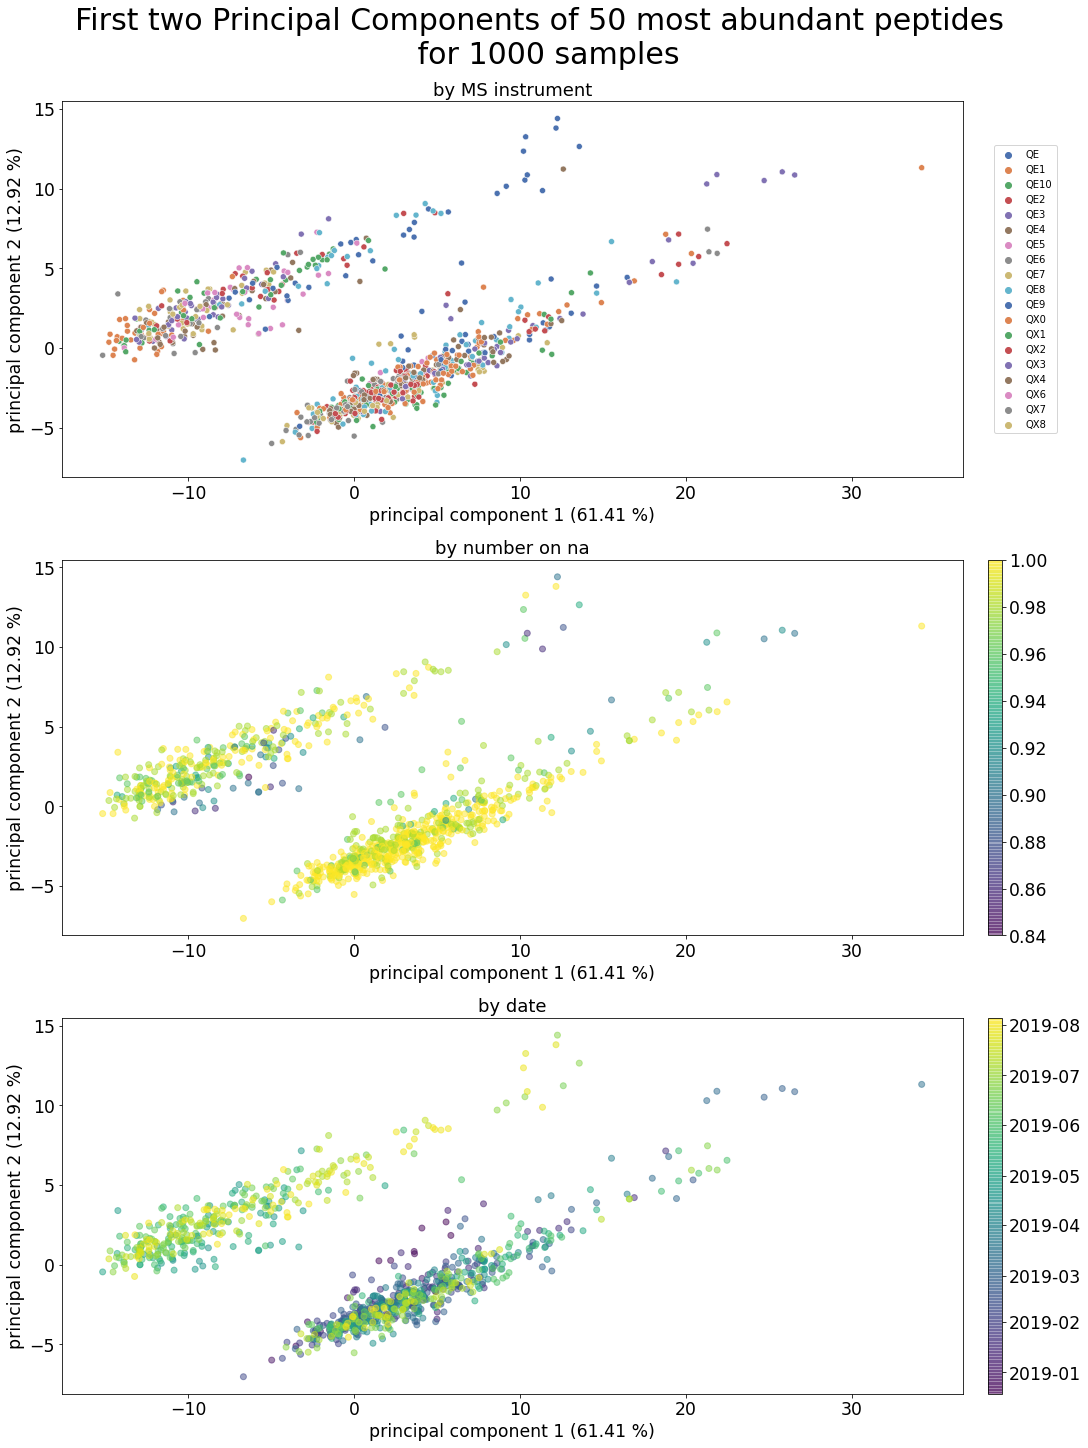

In [17]:
fig = analysis.plot_pca()

In [18]:
# ToDo add df_meta property
analysis.df_meta.describe()

,prop_not_na
count,"1,000.000"
mean,0.984
std,0.026
min,0.840
25%,0.980
50%,1.000
75%,1.000
max,1.000


In [19]:
vaep.io_images._savefig(fig, folder /
                        f'pca_plot_raw_data_{analysis.fname_stub}')

vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\pca_plot_raw_data_N01000_M00050


## Train and Validation data

- use mulitindex for obtaining validation split

In [20]:
# analysis._df_long = analysis.df_long.reset_index(
# ).set_index(['Sample ID', 'peptide'])
analysis.df_long

intensity
Sample ID                           peptide                            
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 SLAGSSGPGASSGTSGDHGELVVR     29.101
                                    LVSNHSLHETSSVFVDSLTK         29.257
                                    LFIGGLNTETNEK                28.728
                                    SNFAEALAAHK                  29.618
                                    DSIVHQAGMLK                  26.859
...                                                                 ...
20190805_QE1_nLC2_AB_MNT_HELA_04    AGVNTVTTLVENKK               30.173
                                    VLGTSVESIMATEDR              27.540
                                    LSDGVAVLK                    31.702
                                    DILLRPELEELR                 27.801
                                    LSPPYSSPQEFAQDVGR            26.405

[49188 rows x 1 columns]

In [21]:
# df_long = analysis.df.unstack().to_frame('intensity').reset_index(1)
analysis.df_train = analysis.df_long.reset_index(0).groupby(
    by='Sample ID',
    level=0
).sample(frac=0.90,
         weights=freq_per_peptide,
         random_state=42)
analysis.df_train = analysis.df_train.reset_index().set_index([
    'Sample ID', 'peptide'])
analysis.df_train

,,intensity
Sample ID,peptide,
20190411_QE6_LC6_AS_QC_MNT_HeLa_03,AAYLQETGKPLDETLK,28.117
20190730_QE1_nLC2_GP_MNT_HELA_02,AAYLQETGKPLDETLK,29.394
20190624_QE6_LC4_AS_QC_MNT_HeLa_02,AAYLQETGKPLDETLK,25.263
20190528_QX2_SeVW_MA_HeLa_500ng_LC05_CTCDoff_1,AAYLQETGKPLDETLK,29.657
20190208_QE2_NLC1_AB_QC_MNT_HELA_3,AAYLQETGKPLDETLK,28.857
...,...,...
20190717_QX3_OzKa_MA_Hela_500ng_LC15_190720214645,YDDMATCMK,30.811
20190219_QE10_nLC14_FaCo_QC_HeLa_50cm_20190219185517,YDDMATCMK,28.469
20190204_QE9_nLC9_NHS_MNT_HELA_45cm_Newcolm_02,YDDMATCMK,27.720


In [22]:
analysis.indices_valid = analysis.df_long.index.difference(
    analysis.df_train.index)
analysis.df_valid = analysis.df_long.loc[analysis.indices_valid]

In [23]:
assert len(analysis.df_long) == len(analysis.df_train) + len(analysis.df_valid)

Check that all samples are also in the validation data

In [24]:
assert analysis.df_train.index.levshape == (N_SAMPLES, n_features)

try:
    assert analysis.df_valid.index.levshape == (N_SAMPLES, n_features)
except AssertionError:
    print(f'Expected shape in validation: {(N_SAMPLES, n_features)}')
    print(f'Shape in validation: {analysis.df_valid.index.levshape}')

analysis.df_train = analysis.df_train.loc[analysis.df_valid.index.levels[0]]
analysis.df_train = analysis.df_train.reset_index().set_index(
    ['Sample ID', 'peptide'])  # update index categories (there is probably a better way)
N_SAMPLES = analysis.df_valid.index.levshape[0]
analysis.df_train.index.levshape, analysis.df_valid.index.levshape

Expected shape in validation: (1000, 50)
Shape in validation: (997, 50)


((997, 50), (997, 50))

## Setup DL

- [ ] move all above to separate data notebook

In [25]:
import vaep.models as models
from vaep.models.cmd import get_args
from vaep.models import ae

args = get_args(batch_size=BATCH_SIZE, epochs=EPOCHS,
                no_cuda=False)  # data transfer to GPU seems slow
kwargs = {'num_workers': 2, 'pin_memory': True} if args.cuda else {}

# torch.manual_seed(args.seed)
device = torch.device("cuda" if args.cuda else "cpu")
device

print(f"{args = }", f"{device = }", sep='\n')

args = Namespace(batch_size=32, cuda=True, epochs=10, log_interval=10, no_cuda=False, seed=43)
device = device(type='cuda')


Fastai default device for computation

In [26]:
import fastai.torch_core
print(f"{torch.cuda.is_available() = }")  # self-documenting python 3.8
fastai.torch_core.defaults

torch.cuda.is_available() = True


namespace(cpus=12,
          use_cuda=None,
          activation=torch.nn.modules.activation.ReLU,
          callbacks=[fastai.callback.core.TrainEvalCallback,
                     fastai.learner.Recorder,
                     fastai.callback.progress.ProgressCallback],
          lr=0.001)

### Comparison data

- first impute first and last row (using n=3 replicate)
- use pandas interpolate

In [27]:
analysis.median_train = analysis.df_train['intensity'].unstack().median()
analysis.median_train.name = 'train_median'
analysis.averag_train = analysis.df_train['intensity'].unstack().mean()
analysis.averag_train.name = 'train_average'

df_pred = analysis.df_valid.copy()

df_pred = df_pred.join(analysis.median_train, on='peptide')
df_pred = df_pred.join(analysis.averag_train, on='peptide')


_ = interpolate(wide_df=analysis.df_train['intensity'].unstack())
df_pred = df_pred.join(_)

df_pred

intensity  \
Sample ID                           peptide                        
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 AAYLQETGKPLDETLK      28.703   
                                    AVFVDLEPTVIDEVR       32.479   
                                    EDQTEYLEER            30.817   
                                    SLHDAIMIVR            27.467   
                                    VACIGAWHPAR           28.940   
...                                                          ...   
20190805_QE1_nLC2_AB_MNT_HELA_04    DILLRPELEELR          27.801   
                                    DYGNSPLHR             28.299   
                                    IITLTGPTNAIFK         29.647   
                                    LFIGGLNTETNEK         29.555   
                                    SPYTVTVGQACNPSACR     28.526   

                                                       train_median  \
Sample ID                           peptide                           
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 AAYLQETGKPLDETLK         28.909   
                                    AVFVDLEPTVIDEVR          32.781   
                                    EDQTEYLEER               31.696   
                                    SLHDAIMIVR               28.452   
                                    VACIGAWHPAR              30.359   
...                                                             ...   
20190805_QE1_nLC2_AB_MNT_HELA_04    DILLRPELEELR             27.788   
                                    DYGNSPLHR                28.399   
                                    IITLTGPTNAIFK            29.899   
                                    LFIGGLNTETNEK            29.769   
                                    SPYTVTVGQACNPSACR        28.393   

                                                       train_average  \
Sample ID                           peptide                            
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 AAYLQETGKPLDETLK          29.133   
                                    AVFVDLEPTVIDEVR           32.496   
                                    EDQTEYLEER                31.780   
                                    SLHDAIMIVR                28.578   
                                    VACIGAWHPAR               30.262   
...                                                              ...   
20190805_QE1_nLC2_AB_MNT_HELA_04    DILLRPELEELR              27.747   
                                    DYGNSPLHR                 28.869   
                                    IITLTGPTNAIFK             30.090   
                                    LFIGGLNTETNEK             29.673   
                                    SPYTVTVGQACNPSACR         28.237   

                                                       replicates  
Sample ID                           peptide                        
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 AAYLQETGKPLDETLK       28.444  
                                    AVFVDLEPTVIDEVR        32.449  
                                    EDQTEYLEER             31.238  
                                    SLHDAIMIVR             27.372  
                                    VACIGAWHPAR            29.478  
...                                                           ...  
20190805_QE1_nLC2_AB_MNT_HELA_04    DILLRPELEELR           28.212  
                                    DYGNSPLHR              28.484  
                                    IITLTGPTNAIFK          29.786  
                                    LFIGGLNTETNEK          29.663  
                                    SPYTVTVGQACNPSACR      28.659  

[4918 rows x 4 columns]

In [28]:
if any(df_pred.isna()):
    print("Consecutive NaNs are not imputed using replicates.")
    display(df_pred.loc[df_pred.isna().any(axis=1)])

Consecutive NaNs are not imputed using replicates.


intensity  \
Sample ID                                            peptide                               
20181229_QE5_nLC5_OOE_QC_MNT_HELA_15cm_250ng_RO-052  ILLAELEQLK                   32.512   
                                                     SLAGSSGPGASSGTSGDHGELVVR     30.218   
20181229_QE5_nLC5_OOE_QC_MNT_HELA_15cm_250ng_RO-053  ILLAELEQLK                   32.572   
20190107_QE5_nLC5_DS_QC_MNT_HeLa_FlashPack_03        IITLTGPTNAIFK                29.401   
20190108_QE1_nLC2_MB_QC_MNT_HELA_old_01              DYGNSPLHR                    28.052   
...                                                                                  ...   
20190722_QE10_nLC0_LiNi_QC_45cm_HeLa_MUC_3rdcolumn_4 SDVLELTDDNFESR               29.654   
20190722_QX3_MiWi_MA_Hela_500ng_LC15                 TFVNITPAEVGVLVGK             33.549   
20190729_QX3_MiWi_MA_Hela_500ng_LC15                 TLGILGLGR                    29.599   
20190803_QE9_nLC13_RG_SA_HeLa_50cm_400ng             IITLTGPTNAIFK                31.492   
20190803_QX8_AnPi_MA_HeLa_BR14_500ng                 SLHDAIMIVR                   30.376   

                                                                               train_median  \
Sample ID                                            peptide                                  
20181229_QE5_nLC5_OOE_QC_MNT_HELA_15cm_250ng_RO-052  ILLAELEQLK                      32.279   
                                                     SLAGSSGPGASSGTSGDHGELVVR        30.587   
20181229_QE5_nLC5_OOE_QC_MNT_HELA_15cm_250ng_RO-053  ILLAELEQLK                      32.279   
20190107_QE5_nLC5_DS_QC_MNT_HeLa_FlashPack_03        IITLTGPTNAIFK                   29.899   
20190108_QE1_nLC2_MB_QC_MNT_HELA_old_01              DYGNSPLHR                       28.399   
...                                                                                     ...   
20190722_QE10_nLC0_LiNi_QC_45cm_HeLa_MUC_3rdcolumn_4 SDVLELTDDNFESR                  29.275   
20190722_QX3_MiWi_MA_Hela_500ng_LC15                 TFVNITPAEVGVLVGK                33.075   
20190729_QX3_MiWi_MA_Hela_500ng_LC15                 TLGILGLGR                       28.820   
20190803_QE9_nLC13_RG_SA_HeLa_50cm_400ng             IITLTGPTNAIFK                   29.899   
20190803_QX8_AnPi_MA_HeLa_BR14_500ng                 SLHDAIMIVR                      28.452   

                                                                               train_average  \
Sample ID                                            peptide                                   
20181229_QE5_nLC5_OOE_QC_MNT_HELA_15cm_250ng_RO-052  ILLAELEQLK                       32.106   
                                                     SLAGSSGPGASSGTSGDHGELVVR         30.745   
20181229_QE5_nLC5_OOE_QC_MNT_HELA_15cm_250ng_RO-053  ILLAELEQLK                       32.106   
20190107_QE5_nLC5_DS_QC_MNT_HeLa_FlashPack_03        IITLTGPTNAIFK                    30.090   
20190108_QE1_nLC2_MB_QC_MNT_HELA_old_01              DYGNSPLHR                        28.869   
...                                                                                      ...   
20190722_QE10_nLC0_LiNi_QC_45cm_HeLa_MUC_3rdcolumn_4 SDVLELTDDNFESR                   29.288   
20190722_QX3_MiWi_MA_Hela_500ng_LC15                 TFVNITPAEVGVLVGK                 32.797   
20190729_QX3_MiWi_MA_Hela_500ng_LC15                 TLGILGLGR                        28.572   
20190803_QE9_nLC13_RG_SA_HeLa_50cm_400ng             IITLTGPTNAIFK                    30.090   
20190803_QX8_AnPi_MA_HeLa_BR14_500ng                 SLHDAIMIVR                       28.578   

                                                                               replicates  
Sample ID                                            peptide                               
20181229_QE5_nLC5_OOE_QC_MNT_HELA_15cm_250ng_RO-052  ILLAELEQLK                       NaN  
                                                     SLAGSSGPGASSGTSGDHGELVVR         NaN  
20181229_QE5_nLC5_OOE_QC_MNT_

## Collaboritive filtering model

In [29]:
from fastai.collab import CollabDataLoaders, MSELossFlat, Learner
from fastai.collab import EmbeddingDotBias

analysis.collab = Analysis()
collab = analysis.collab
collab.columns = 'peptide,Sample ID,intensity'.split(',')

Create data view for collaborative filtering

- currently a bit hacky as the splitter does not support predefinded indices (create custum subclass providing splits to internal methods?)

- Use the [`CollabDataLoaders`](https://docs.fast.ai/collab.html#CollabDataLoaders)  similar to the [`TabularDataLoaders`](https://docs.fast.ai/tabular.data.html#TabularDataLoaders).
- Use the [`IndexSplitter`](https://docs.fast.ai/data.transforms.html#IndexSplitter) and provide splits to whatever is used in `CollabDataLoaders`


In [30]:
collab.df_train = analysis.df_train.reset_index()
collab.df_valid = analysis.df_valid.reset_index()
collab.df_train.head()

,Sample ID,peptide,intensity
0,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,AGVNTVTTLVENKK,28.355
1,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,ALDTMNFDVIK,28.452
2,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,AVAQALEVIPR,28.257
3,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,AVLVDLEPGTMDSVR,30.155
4,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,DILLRPELEELR,27.630


In [31]:
collab.df_valid.head()

,Sample ID,peptide,intensity
0,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,AAYLQETGKPLDETLK,28.703
1,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,AVFVDLEPTVIDEVR,32.479
2,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,EDQTEYLEER,30.817
3,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,SLHDAIMIVR,27.467
4,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,VACIGAWHPAR,28.940


In [32]:
assert (collab.df_train.intensity.isna().sum(),
        collab.df_valid.intensity.isna().sum()) == (0, 0), "Remove missing values."

Hacky part uses training data `Datasets` from dataloaders to recreate a custom `DataLoaders` instance

In [33]:
collab.dl_train = CollabDataLoaders.from_df(
    collab.df_train, valid_pct=0.0, user_name='Sample ID', item_name='peptide', rating_name='intensity', bs=args.batch_size, device=device)
collab.dl_valid = CollabDataLoaders.from_df(
    collab.df_valid, valid_pct=0.0, user_name='Sample ID', item_name='peptide', rating_name='intensity', bs=args.batch_size,
    shuffle=False, device=device)
collab.dl_train.show_batch()

,Sample ID,peptide,intensity
0,20190313_QE1_nLC2_GP_QC_MNT_HELA_02_20190315065501,IVSRPEELREDDVGTGAGLLEIK,29.975
1,20190611_QE4_LC12_JE_QC_MNT_HeLa_02,MLDAEDIVNTARPDEK,30.878
2,20190515_QE2_NLC1_GP_MNT_HELA_01,SLHDAIMIVR,27.207
3,20190204_QE6_nLC6_MPL_QC_MNT_HeLa_02,TLGILGLGR,28.871
4,20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,SNFAEALAAHK,29.471
5,20190228_QE4_LC12_JE_QC_MNT_HeLa_02,SDVLELTDDNFESR,28.544
6,20190530_QX2_SeVW_MA_HeLa_500ng_LC05_CTCDoff_1,LFIGGLNTETNEK,31.401
7,20190312_QE8_nLC14_LiNi_QC_MNT_50cm_HELA_02,TFCQLILDPIFK,30.610
8,20190606_QE4_LC12_JE_QC_MNT_HeLa_01,ILATPPQEDAPSVDIANIR,30.635
9,20181227_QE6_nLC6_CSC_QC_MNT_HeLa_01,AVAQALEVIPR,27.937


In [34]:
from fastai.data.core import DataLoaders
collab.dls = DataLoaders(collab.dl_train.train, collab.dl_valid.train)
if args.cuda:
    collab.dls.cuda()

In [35]:
collab.dl_valid.show_batch()

,Sample ID,peptide,intensity
0,20190131_QE6_LC6_AS_MNT_HeLa_02,TLGILGLGR,28.858
1,20190626_QX6_ChDe_MA_HeLa_500ng_LC09,SLHDAIMIVR,31.050
2,20190111_QE2_NLC10_ANHO_QC_MNT_HELA_01,VLGTSVESIMATEDR,27.758
3,20190731_QX8_ChSc_MA_HeLa_500ng,LFIGGLNTETNEK,30.852
4,20190402_QE1_nLC2_GP_MNT_QC_hela_01,TISHVIIGLK,27.552
5,20190702_QE9_nLC0_RG_MNT_Hela_MUC_50cm_1,LSDGVAVLK,31.737
6,20190114_QE4_LC6_IAH_QC_MNT_HeLa_250ng_02,TNQELQEINR,31.190
7,20190327_QE6_LC6_SCL_QC_MNT_Hela_01,RAGELTEDEVER,30.221
8,20190331_QE10_nLC13_LiNi_QC_45cm_HeLa_01_20190401142408,TISHVIIGLK,28.727
9,20190303_QE9_nLC0_FaCo_QC_MNT_Hela_50cm_newcol_20190304104835,ILATPPQEDAPSVDIANIR,29.567


In [36]:
len(collab.dls.classes['Sample ID']), len(collab.dls.classes['peptide'])

(998, 51)

In [37]:
len(collab.dls.train), len(collab.dls.valid)  # mini-batches

(1378, 154)

Alternatively to the hacky version, one could use a factory method, but there the sampling/Splitting methods would need to be implemented (not using [`RandomSplitter`](https://docs.fast.ai/data.transforms.html#RandomSplitter) somehow)

 - [`TabDataLoader`](https://docs.fast.ai/tabular.core.html#TabDataLoader)
 - uses [`TabularPandas`](https://docs.fast.ai/tabular.core.html#TabularPandas)
 
 > Current problem: No custom splitter can be provided

### Model

In [38]:
collab.model_args = {}
collab.model_args['n_samples'] = len(collab.dls.classes['Sample ID'])
collab.model_args['n_peptides'] = len(collab.dls.classes['peptide'])
collab.model_args['dim_latent_factors'] = latent_dim
collab.model_args['y_range'] = (
    int(analysis.df_train['intensity'].min()), int(analysis.df_train['intensity'].max())+1)

print("Args:")
pprint(collab.model_args)


# from vaep.models.collab import DotProductBias
# model = DotProductBias(**collab.model_args)
model = EmbeddingDotBias.from_classes(
    n_factors=collab.model_args['dim_latent_factors'], classes=collab.dls.classes, y_range=collab.model_args['y_range'])
learn = Learner(dls=collab.dls, model=model, loss_func=MSELossFlat())
if args.cuda:
    learn.cuda()
learn.summary()

Args:
{'dim_latent_factors': 2,
 'n_peptides': 51,
 'n_samples': 998,
 'y_range': (21, 36)}


EmbeddingDotBias (Input shape: 32 x 2)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 2              
Embedding                                 1996       True      
Embedding                                 102        True      
____________________________________________________________________________
                     32 x 1              
Embedding                                 998        True      
Embedding                                 51         True      
____________________________________________________________________________

Total params: 3,147
Total trainable params: 3,147
Total non-trainable params: 0

Optimizer used: <function Adam at 0x000001C51BF85040>
Loss function: FlattenedLoss of MSELoss()

Callbacks:
  - TrainEvalCallback
  - Recorder
  - ProgressCallback

### Training

In [39]:
learn.fit_one_cycle(epochs_max, 5e-3)

epoch,train_loss,valid_loss,time
0,1.782035,1.569148,00:08
1,0.638906,0.634213,00:08
2,0.539817,0.520697,00:09
3,0.488163,0.498128,00:09
4,0.460502,0.493117,00:08
5,0.534325,0.484686,00:09
6,0.464376,0.473312,00:08
7,0.457070,0.466557,00:08
8,0.465899,0.467532,00:08
9,0.465885,0.467376,00:09


vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\collab_training


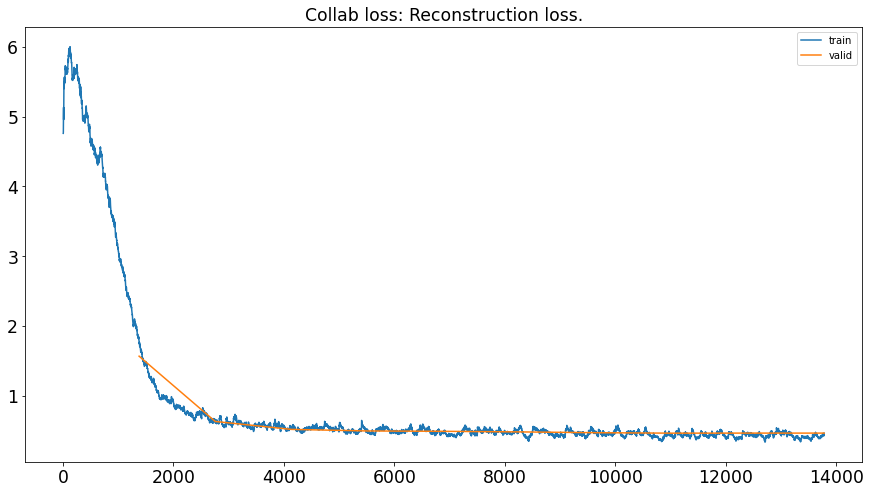

In [40]:
from vaep.models import plot_loss
from fastai import learner
learner.Recorder.plot_loss = plot_loss

fig, ax = plt.subplots(figsize=(15, 8))
ax.set_title('Collab loss: Reconstruction loss.')
learn.recorder.plot_loss(skip_start=5, ax=ax)
vaep.io_images._savefig(fig, name='collab_training',
                        folder=folder)

### Evaluation

In [41]:
collab.dls.valid_ds.items

,Sample ID,peptide,intensity
488,103,46,28.858
"3,678",754,36,31.050
206,42,49,27.758
"4,753",965,23,30.852
"1,669",337,45,27.552
...,...,...,...
845,171,44,31.769
"4,004",815,40,33.270
"3,534",725,50,28.106
"4,376",890,44,31.764


In [42]:
df_pred = df_pred.reset_index()
pred, target = learn.get_preds()
df_pred['intensity_pred_collab'] = pd.Series(
    pred.flatten().numpy(), index=collab.dls.valid.items.index)

npt.assert_almost_equal(
    actual=collab.dls.valid.items.intensity.to_numpy(),
    desired=target.numpy().flatten()
)


df_pred = analyzers.cast_object_to_category(df_pred)
df_pred.set_index(['Sample ID', 'peptide'], inplace=True)
df_pred

intensity  \
Sample ID                           peptide                        
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 AAYLQETGKPLDETLK      28.703   
                                    AVFVDLEPTVIDEVR       32.479   
                                    EDQTEYLEER            30.817   
                                    SLHDAIMIVR            27.467   
                                    VACIGAWHPAR           28.940   
...                                                          ...   
20190805_QE1_nLC2_AB_MNT_HELA_04    DILLRPELEELR          27.801   
                                    DYGNSPLHR             28.299   
                                    IITLTGPTNAIFK         29.647   
                                    LFIGGLNTETNEK         29.555   
                                    SPYTVTVGQACNPSACR     28.526   

                                                       train_median  \
Sample ID                           peptide                           
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 AAYLQETGKPLDETLK         28.909   
                                    AVFVDLEPTVIDEVR          32.781   
                                    EDQTEYLEER               31.696   
                                    SLHDAIMIVR               28.452   
                                    VACIGAWHPAR              30.359   
...                                                             ...   
20190805_QE1_nLC2_AB_MNT_HELA_04    DILLRPELEELR             27.788   
                                    DYGNSPLHR                28.399   
                                    IITLTGPTNAIFK            29.899   
                                    LFIGGLNTETNEK            29.769   
                                    SPYTVTVGQACNPSACR        28.393   

                                                       train_average  \
Sample ID                           peptide                            
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 AAYLQETGKPLDETLK          29.133   
                                    AVFVDLEPTVIDEVR           32.496   
                                    EDQTEYLEER                31.780   
                                    SLHDAIMIVR                28.578   
                                    VACIGAWHPAR               30.262   
...                                                              ...   
20190805_QE1_nLC2_AB_MNT_HELA_04    DILLRPELEELR              27.747   
                                    DYGNSPLHR                 28.869   
                                    IITLTGPTNAIFK             30.090   
                                    LFIGGLNTETNEK             29.673   
                                    SPYTVTVGQACNPSACR         28.237   

                                                       replicates  \
Sample ID                           peptide                         
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 AAYLQETGKPLDETLK       28.444   
                                    AVFVDLEPTVIDEVR        32.449   
                                    EDQTEYLEER             31.238   
                                    SLHDAIMIVR             27.372   
                                    VACIGAWHPAR            29.478   
...                                                           ...   
20190805_QE1_nLC2_AB_MNT_HELA_04    DILLRPELEELR           28.212   
                                    DYGNSPLHR              28.484   
                                    IITLTGPTNAIFK          29.786   
                                    LFIGGLNTETNEK          29.663   
                                    SPYTVTVGQACNPSACR      28.659   

                                                       intensity_pred_collab  
Sample ID                           peptide                                   
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 AAYLQETGKPLDETLK                  28.277  
                                    AVFVDLEPTVIDEVR                   31.831  
                                    EDQTEYLEER                        30.927  
                

In [43]:
assert (abs(target.reshape(-1) - pred.reshape(-1))).sum() / len(target) - \
    (df_pred.intensity - df_pred.intensity_pred_collab).abs().sum() / \
    len(df_pred) < 0.00001

### Plot biases and embedding weigths

- visualize relative order of samples and peptides

In [44]:
from collections import namedtuple
def get_bias(learner, indices, is_item=True) -> pd.Series:
    ret = learner.model.bias(indices.values, is_item=is_item) # user=sample
    return pd.Series(ret, index=indices)

# def get_weigths

CollabIDs = namedtuple("CollabIDs", "sample peptide")

collab.biases = CollabIDs(
    sample=get_bias(learn, indices=analysis.df_train.index.levels[0], is_item=False), # item=peptide
    peptide=get_bias(learn, indices=analysis.df_train.index.levels[1] )
)
collab.biases.sample.head()

Sample ID
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02     0.067
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01    0.064
20181221_QE8_nLC0_NHS_MNT_HeLa_01       0.198
20181222_QE9_nLC9_QC_50CM_HeLa1         0.120
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01   0.153
dtype: float32

vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\collab_bias_samples


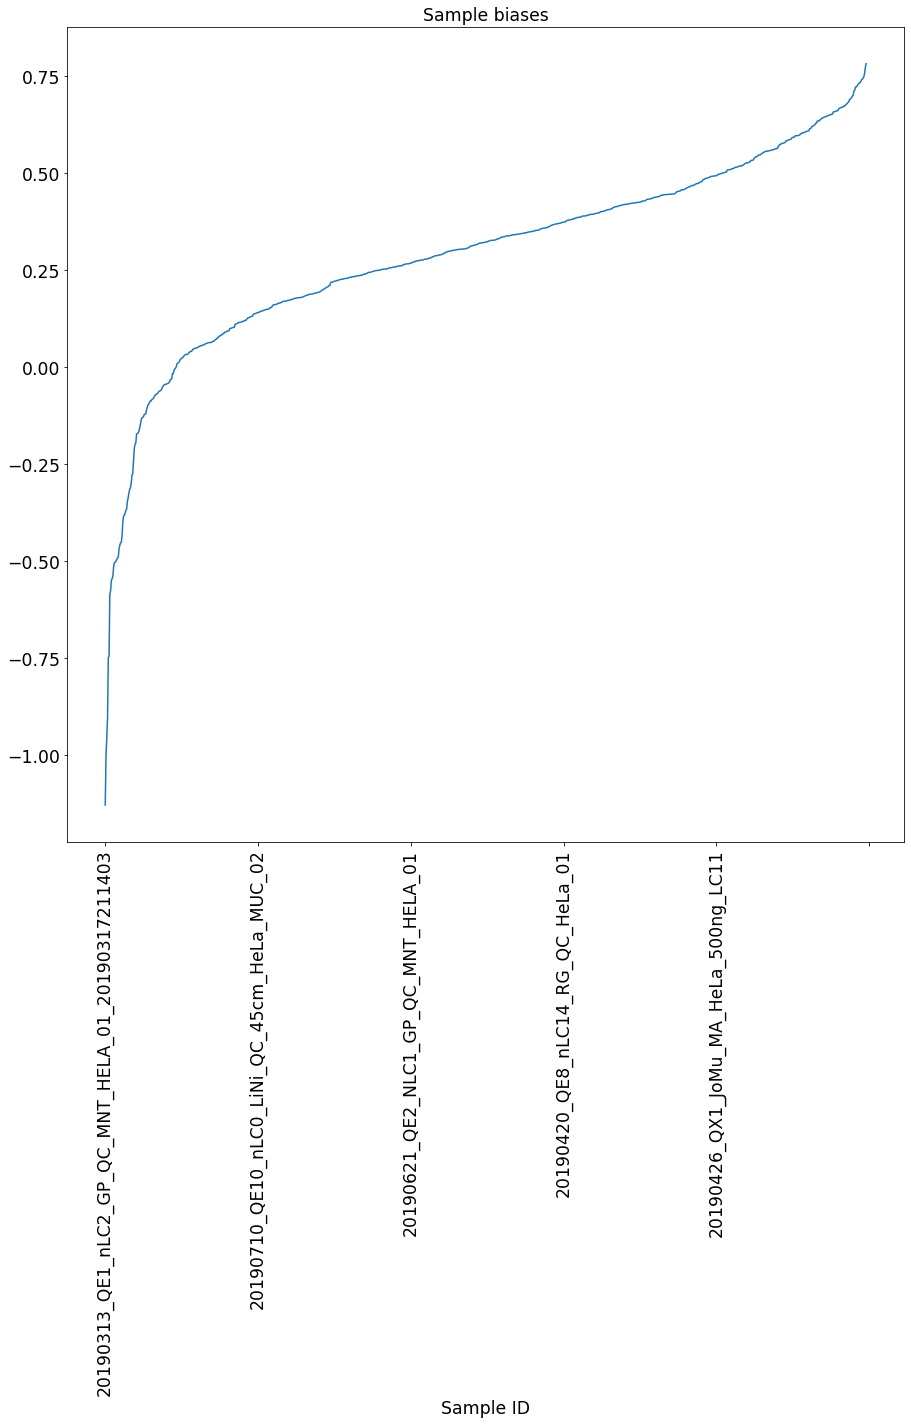

In [45]:
fig, ax = plt.subplots(figsize=(15, 15))
ax = collab.biases.sample.sort_values().plot(kind='line', rot=90, title='Sample biases', ax=ax)
vaep.io_images._savefig(fig, name='collab_bias_samples',
                        folder=folder)

vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\collab_bias_peptides


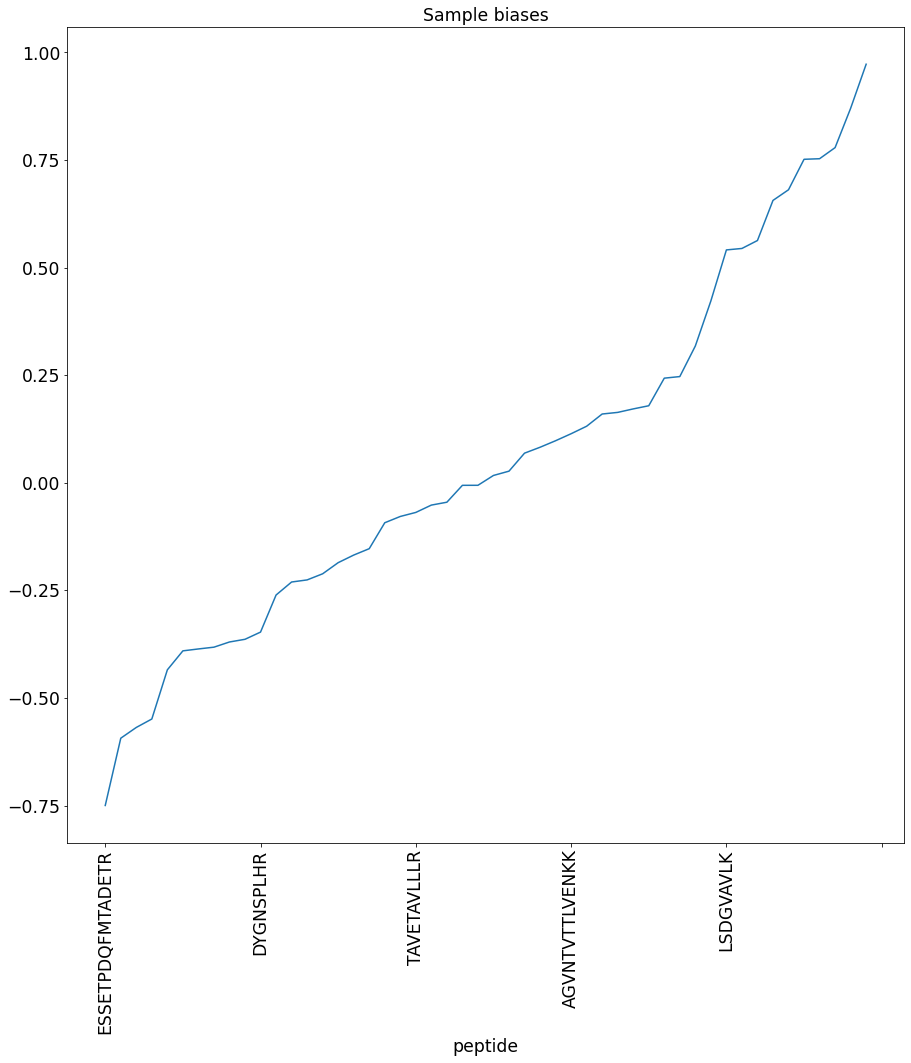

In [46]:
fig, ax = plt.subplots(figsize=(15, 15))
_ = collab.biases.peptide.sort_values().plot(kind='line', rot=90, title='Sample biases', ax=ax)
vaep.io_images._savefig(fig, name='collab_bias_peptides',
                        folder=folder)

In [47]:
def get_weight(learner, indices, is_item=True) -> pd.Series:
    ret = learner.model.weight(indices.values, is_item=is_item) # user=sample
    return pd.DataFrame(ret, index=indices, columns=[f'latent dimension {i+1}' for i in range(ret.shape[-1])])

collab.embeddings = CollabIDs(
    sample=get_weight(learn, indices=analysis.df_train.index.levels[0], is_item=False), # item=peptide
    peptide=get_weight(learn, indices=analysis.df_train.index.levels[1] )
)
collab.embeddings.sample.head()

,latent dimension 1,latent dimension 2
Sample ID,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,-0.049,0.069
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,-0.075,0.047
20181221_QE8_nLC0_NHS_MNT_HeLa_01,0.081,0.002
20181222_QE9_nLC9_QC_50CM_HeLa1,-0.093,0.031
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,0.048,0.266


vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\collab_latent_by_date


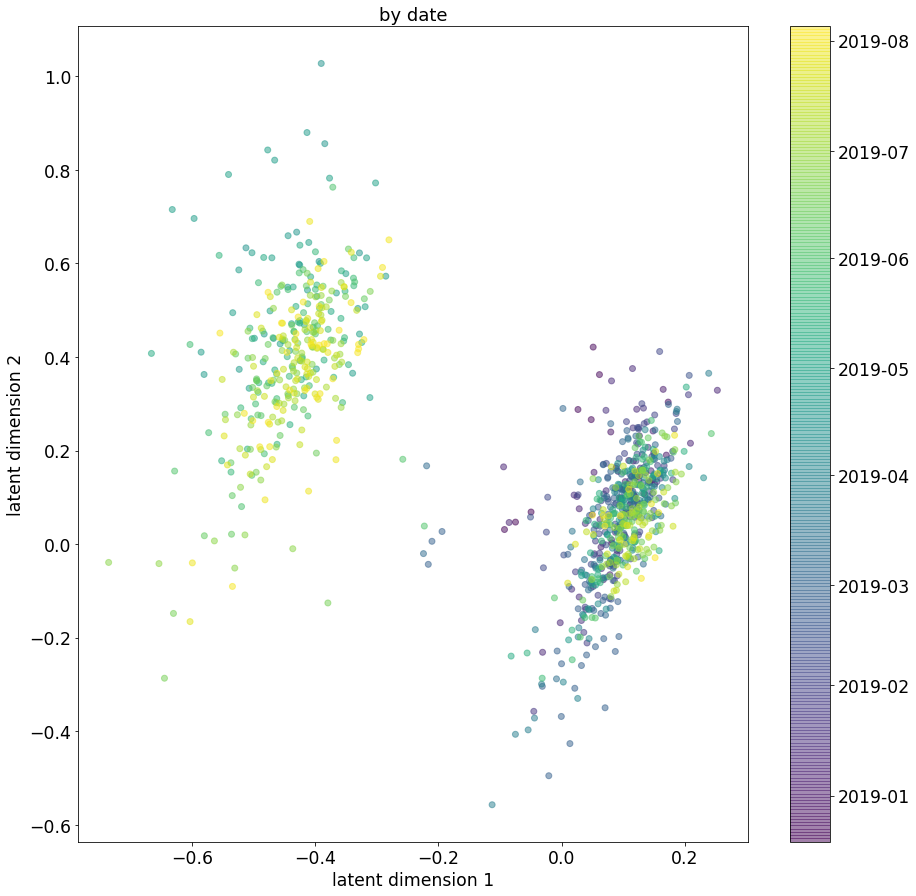

In [48]:
fig, ax = plt.subplots(figsize=(15, 15))
analyzers.plot_date_map(df=collab.embeddings.sample, fig=fig, ax=ax,
                        dates=analysis.df_meta.date.loc[collab.embeddings.sample.index])
vaep.io_images._savefig(fig, name='collab_latent_by_date',
                        folder=folder)

vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\collab_latent_by_ms_instrument


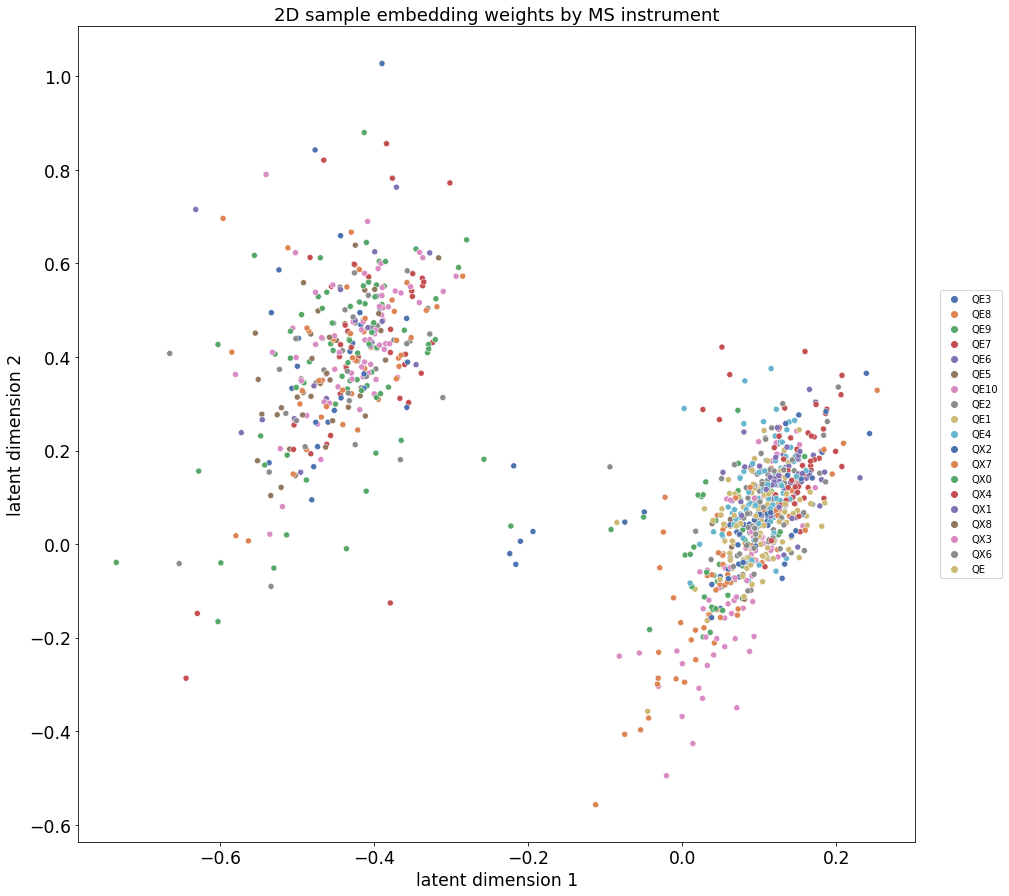

In [49]:
fig, ax = plt.subplots(figsize=(15, 15))
meta_col = 'ms_instrument'

df_ = collab.embeddings.sample
analyzers.seaborn_scatter(df=df_,
                          fig=fig,
                          ax=ax,
                          meta=analysis.df_meta[meta_col].loc[df_.index],
                          title='2D sample embedding weights by MS instrument')

vaep.io_images._savefig(fig, name='collab_latent_by_ms_instrument',
                        folder=folder)

## Denoising Autoencoder (DAE)

### Custom Transforms

- [x] Shift standard normalized data around
    - Error metrics won't be directly comparable afterwards

In [50]:
from fastai.tabular.all import *
from vaep.models import ae

from fastai.tabular.core import TabularPandas

# from fastai.callback.core import Callback

from fastai.data.core import DataLoaders

from fastai.learner import Learner
from fastai.losses import MSELossFlat


# https://docs.fast.ai/tabular.core.html#FillStrategy
# from fastai.tabular.core import FillMissing
# from fastai.tabular.core import TabularPandas

### DataLoaders

In [51]:
# revert format
# undo using `stack`
analysis.df_train = analysis.df_train['intensity'].unstack()
analysis.df_valid = analysis.df_valid['intensity'].unstack()
analysis.df_valid.head()

peptide,AAYLQETGKPLDETLK,AGVNTVTTLVENKK,ALDTMNFDVIK,AVAQALEVIPR,AVFVDLEPTVIDEVR,AVLVDLEPGTMDSVR,DILLRPELEELR,DNSTMGYMMAK,DSIVHQAGMLK,DYGNSPLHR,...,TAVETAVLLLR,TELEDTLDSTAAQQELR,TFCQLILDPIFK,TFVNITPAEVGVLVGK,TISHVIIGLK,TLGILGLGR,TNQELQEINR,VACIGAWHPAR,VLGTSVESIMATEDR,YDDMATCMK
Sample ID,,,,,,,,,,,,,,,,,,,,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,28.703,NaN,NaN,NaN,32.479,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.940,NaN,NaN
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,NaN,28.238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,30.140,NaN,NaN,NaN
20181221_QE8_nLC0_NHS_MNT_HeLa_01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181222_QE9_nLC9_QC_50CM_HeLa1,NaN,NaN,NaN,28.333,31.753,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,31.566,NaN,NaN,NaN,NaN,NaN,27.815
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,NaN,NaN,NaN,NaN,33.876,30.679,NaN,NaN,26.810,NaN,...,NaN,28.438,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Mean and std. dev. from training data

In [52]:
# norm = Normalize.from_stats(analysis.df_train.mean(), analysis.df_valid.std()) # copy interface?
NORMALIZER = Normalize  # dae.NormalizeShiftedMean

#### Training data

procs passed to TabluarPandas are handled internally 
  1. not necessarily in order
  2. with setup call (using current training data)

In [53]:
procs = [NORMALIZER, FillMissing(add_col=True)]
cont_names = list(analysis.df_train.columns)

to = TabularPandas(analysis.df_train, procs=procs, cont_names=cont_names)
print("Tabular object:", type(to))

to.items  # items reveals data in DataFrame

Tabular object: <class 'fastai.tabular.core.TabularPandas'>


peptide,AAYLQETGKPLDETLK,AGVNTVTTLVENKK,ALDTMNFDVIK,AVAQALEVIPR,AVFVDLEPTVIDEVR,AVLVDLEPGTMDSVR,DILLRPELEELR,DNSTMGYMMAK,DSIVHQAGMLK,DYGNSPLHR,...,TAVETAVLLLR_na,TELEDTLDSTAAQQELR_na,TFCQLILDPIFK_na,TFVNITPAEVGVLVGK_na,TISHVIIGLK_na,TLGILGLGR_na,TNQELQEINR_na,VACIGAWHPAR_na,VLGTSVESIMATEDR_na,YDDMATCMK_na
Sample ID,,,,,,,,,,,,,,,,,,,,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,-0.133,-0.983,-0.851,-0.243,0.177,-0.989,-0.109,-0.188,-1.262,-0.678,...,False,False,False,False,False,False,False,True,False,False
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,-0.371,0.273,-0.817,-0.233,-0.046,-1.269,-0.149,0.119,-3.370,-0.120,...,False,False,False,False,False,False,True,False,False,False
20181221_QE8_nLC0_NHS_MNT_HeLa_01,-0.513,0.188,-0.829,-0.576,-0.080,-0.397,-0.955,-0.868,-0.326,-0.843,...,False,False,False,False,False,False,False,False,False,False
20181222_QE9_nLC9_QC_50CM_HeLa1,-0.509,-0.972,-0.680,-0.300,0.177,-0.551,0.042,0.076,-1.069,-0.239,...,False,False,False,True,False,False,False,False,False,True
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,0.006,-0.972,-0.393,0.126,0.177,-0.036,0.361,0.090,0.122,-0.364,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190805_QE10_nLC0_LiNi_MNT_45cm_HeLa_MUC_02,1.214,-3.046,0.617,1.161,1.238,0.762,0.436,1.212,0.122,1.190,...,True,False,False,False,False,False,False,False,False,True
20190805_QE1_nLC2_AB_MNT_HELA_01,-0.243,0.315,-0.443,-0.828,-0.316,-0.377,0.183,-0.373,0.663,-0.215,...,False,True,False,False,False,False,False,False,False,False
20190805_QE1_nLC2_AB_MNT_HELA_02,0.157,-0.070,-0.340,-0.728,0.095,-0.295,0.612,-0.478,0.431,-0.167,...,False,False,False,False,False,False,False,False,False,False


Better manuelly apply `Transforms` on `Tabluar` type

In [54]:
cont_names = list(analysis.df_train.columns)
to = TabularPandas(analysis.df_train, cont_names=cont_names, do_setup=False)

tf_norm = NORMALIZER()
_ = tf_norm.setups(to)  # returns to
tf_fillna = FillMissing(add_col=True)
_ = tf_fillna.setup(to)

print("Tabular object:", type(to))
# _ = (procs[0]).encodes(to)
to.items  # items reveals data in DataFrame

Tabular object: <class 'fastai.tabular.core.TabularPandas'>


peptide,AAYLQETGKPLDETLK,AGVNTVTTLVENKK,ALDTMNFDVIK,AVAQALEVIPR,AVFVDLEPTVIDEVR,AVLVDLEPGTMDSVR,DILLRPELEELR,DNSTMGYMMAK,DSIVHQAGMLK,DYGNSPLHR,...,TAVETAVLLLR_na,TELEDTLDSTAAQQELR_na,TFCQLILDPIFK_na,TFVNITPAEVGVLVGK_na,TISHVIIGLK_na,TLGILGLGR_na,TNQELQEINR_na,VACIGAWHPAR_na,VLGTSVESIMATEDR_na,YDDMATCMK_na
Sample ID,,,,,,,,,,,,,,,,,,,,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,-0.141,-0.883,-0.799,-0.265,0.192,-0.941,-0.099,-0.239,-1.179,-0.669,...,False,False,False,False,False,False,False,True,False,False
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,-0.367,0.295,-0.766,-0.256,-0.015,-1.207,-0.138,0.046,-3.171,-0.143,...,False,False,False,False,False,False,True,False,False,False
20181221_QE8_nLC0_NHS_MNT_HeLa_01,-0.501,0.215,-0.778,-0.582,-0.047,-0.381,-0.899,-0.872,-0.294,-0.825,...,False,False,False,False,False,False,False,False,False,False
20181222_QE9_nLC9_QC_50CM_HeLa1,-0.498,-0.872,-0.638,-0.320,0.192,-0.526,0.044,0.007,-0.996,-0.255,...,False,False,False,True,False,False,False,False,False,True
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,-0.009,-0.872,-0.368,0.085,0.192,-0.037,0.345,0.020,0.129,-0.373,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190805_QE10_nLC0_LiNi_MNT_45cm_HeLa_MUC_02,1.138,-2.816,0.579,1.067,1.176,0.719,0.416,1.063,0.129,1.094,...,True,False,False,False,False,False,False,False,False,True
20190805_QE1_nLC2_AB_MNT_HELA_01,-0.245,0.334,-0.415,-0.820,-0.266,-0.361,0.176,-0.412,0.641,-0.232,...,False,True,False,False,False,False,False,False,False,False
20190805_QE1_nLC2_AB_MNT_HELA_02,0.135,-0.027,-0.318,-0.726,0.115,-0.284,0.582,-0.509,0.421,-0.187,...,False,False,False,False,False,False,False,False,False,False


Check mean and standard deviation after normalization

In [55]:
to.items.iloc[:, :10].describe()  # not perferct anymore as expected

peptide,AAYLQETGKPLDETLK,AGVNTVTTLVENKK,ALDTMNFDVIK,AVAQALEVIPR,AVFVDLEPTVIDEVR,AVLVDLEPGTMDSVR,DILLRPELEELR,DNSTMGYMMAK,DSIVHQAGMLK,DYGNSPLHR
count,997.000,997.000,997.000,997.000,997.000,997.000,997.000,997.000,997.000,997.000
mean,-0.014,0.039,0.000,-0.035,0.027,-0.004,0.004,-0.064,0.014,-0.029
std,0.949,0.938,0.939,0.949,0.929,0.949,0.945,0.931,0.946,0.945
min,-3.738,-4.901,-4.602,-3.254,-5.119,-5.169,-5.141,-2.509,-4.583,-3.229
25%,-0.465,-0.100,-0.423,-0.632,-0.298,-0.442,-0.390,-0.658,-0.362,-0.622
50%,-0.141,0.295,0.003,-0.320,0.192,-0.037,0.034,-0.412,0.129,-0.255
75%,0.454,0.576,0.427,0.883,0.539,0.492,0.499,0.677,0.604,0.784
max,2.085,1.624,1.941,2.086,1.758,1.967,2.723,1.903,1.959,2.106


Mask is added as type bool

In [56]:
to.items.dtypes.value_counts()

bool      50
float64   50
dtype: int64

with the suffix `_na` where `True` is indicating a missing value replaced by the `FillMissing` transformation

In [57]:
to.cont_names, to.cat_names

((#50) ['AAYLQETGKPLDETLK','AGVNTVTTLVENKK','ALDTMNFDVIK','AVAQALEVIPR','AVFVDLEPTVIDEVR','AVLVDLEPGTMDSVR','DILLRPELEELR','DNSTMGYMMAK','DSIVHQAGMLK','DYGNSPLHR'...],
 (#50) ['AAYLQETGKPLDETLK_na','AGVNTVTTLVENKK_na','ALDTMNFDVIK_na','AVAQALEVIPR_na','AVFVDLEPTVIDEVR_na','AVLVDLEPGTMDSVR_na','DILLRPELEELR_na','DNSTMGYMMAK_na','DSIVHQAGMLK_na','DYGNSPLHR_na'...])

In [58]:
assert len(to.valid) == 0

#### Validation data

- reuse training data with different mask for evaluation
- target data is the validation data
    - switch between training and evaluation mode for setting comparison

In [59]:
_df_valid = TabularPandas(
    analysis.df_valid, cont_names=analysis.df_valid.columns.tolist())
# assert analysis.df_valid.isna().equals(y_valid.items.isna())
_df_valid = tf_norm.encodes(_df_valid)

In [60]:
_df_valid.items.iloc[:, :10].describe()

peptide,AAYLQETGKPLDETLK,AGVNTVTTLVENKK,ALDTMNFDVIK,AVAQALEVIPR,AVFVDLEPTVIDEVR,AVLVDLEPGTMDSVR,DILLRPELEELR,DNSTMGYMMAK,DSIVHQAGMLK,DYGNSPLHR
count,100.000,97.000,98.000,99.000,95.000,100.000,99.000,94.000,99.000,98.000
mean,-0.122,0.055,0.016,-0.054,0.041,0.122,0.129,0.103,-0.071,-0.082
std,1.053,0.859,0.937,0.927,0.750,0.725,0.901,0.959,1.007,0.865
min,-3.930,-3.385,-2.696,-1.418,-2.291,-1.538,-3.025,-1.802,-2.849,-1.759
25%,-0.654,-0.185,-0.516,-0.761,-0.446,-0.374,-0.354,-0.624,-0.770,-0.575
50%,-0.193,0.195,-0.010,-0.387,0.168,0.007,0.052,-0.279,0.118,-0.322
75%,0.225,0.574,0.601,0.934,0.537,0.506,0.735,1.091,0.666,0.244
max,1.913,1.260,1.706,1.682,1.425,1.807,1.848,1.777,1.782,1.710


In [61]:
# Validation dataset
# build validation DataFrame with mask according to validation data
# FillNA values in data as before, but do not add categorical columns (as this is done manuelly)
_valid_df = to.conts  # same data for predictions
_valid_df = _valid_df.join(analysis.df_valid.isna(), rsuffix='_na')  # mask
_valid_df = _valid_df.join(_df_valid.items, rsuffix='_val')  # target
_valid_df

peptide,AAYLQETGKPLDETLK,AGVNTVTTLVENKK,ALDTMNFDVIK,AVAQALEVIPR,AVFVDLEPTVIDEVR,AVLVDLEPGTMDSVR,DILLRPELEELR,DNSTMGYMMAK,DSIVHQAGMLK,DYGNSPLHR,...,TAVETAVLLLR_val,TELEDTLDSTAAQQELR_val,TFCQLILDPIFK_val,TFVNITPAEVGVLVGK_val,TISHVIIGLK_val,TLGILGLGR_val,TNQELQEINR_val,VACIGAWHPAR_val,VLGTSVESIMATEDR_val,YDDMATCMK_val
Sample ID,,,,,,,,,,,,,,,,,,,,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,-0.141,-0.883,-0.799,-0.265,0.192,-0.941,-0.099,-0.239,-1.179,-0.669,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.036,NaN,NaN
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,-0.367,0.295,-0.766,-0.256,-0.015,-1.207,-0.138,0.046,-3.171,-0.143,...,NaN,NaN,NaN,NaN,NaN,NaN,0.096,NaN,NaN,NaN
20181221_QE8_nLC0_NHS_MNT_HeLa_01,-0.501,0.215,-0.778,-0.582,-0.047,-0.381,-0.899,-0.872,-0.294,-0.825,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181222_QE9_nLC9_QC_50CM_HeLa1,-0.498,-0.872,-0.638,-0.320,0.192,-0.526,0.044,0.007,-0.996,-0.255,...,NaN,NaN,NaN,-1.003,NaN,NaN,NaN,NaN,NaN,-0.453
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,-0.009,-0.872,-0.368,0.085,0.192,-0.037,0.345,0.020,0.129,-0.373,...,NaN,-0.347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190805_QE10_nLC0_LiNi_MNT_45cm_HeLa_MUC_02,1.138,-2.816,0.579,1.067,1.176,0.719,0.416,1.063,0.129,1.094,...,0.955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.964
20190805_QE1_nLC2_AB_MNT_HELA_01,-0.245,0.334,-0.415,-0.820,-0.266,-0.361,0.176,-0.412,0.641,-0.232,...,NaN,0.144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20190805_QE1_nLC2_AB_MNT_HELA_02,0.135,-0.027,-0.318,-0.726,0.115,-0.284,0.582,-0.509,0.421,-0.187,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
# [norm, FillMissing(add_col=False)]  # mask is provided explicitly
procs = None

cont_names = list(analysis.df_train.columns)
cat_names = [f'{s}_na' for s in cont_names]
y_names = [f'{s}_val' for s in cont_names]

splits = None
y_block = None
to_valid = TabularPandas(_valid_df, procs=procs, cat_names=cat_names, cont_names=cont_names,
                         y_names=y_names, splits=splits, y_block=y_block, do_setup=True)
to_valid.items

peptide,AAYLQETGKPLDETLK,AGVNTVTTLVENKK,ALDTMNFDVIK,AVAQALEVIPR,AVFVDLEPTVIDEVR,AVLVDLEPGTMDSVR,DILLRPELEELR,DNSTMGYMMAK,DSIVHQAGMLK,DYGNSPLHR,...,TAVETAVLLLR_val,TELEDTLDSTAAQQELR_val,TFCQLILDPIFK_val,TFVNITPAEVGVLVGK_val,TISHVIIGLK_val,TLGILGLGR_val,TNQELQEINR_val,VACIGAWHPAR_val,VLGTSVESIMATEDR_val,YDDMATCMK_val
Sample ID,,,,,,,,,,,,,,,,,,,,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,-0.141,-0.883,-0.799,-0.265,0.192,-0.941,-0.099,-0.239,-1.179,-0.669,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.036,NaN,NaN
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,-0.367,0.295,-0.766,-0.256,-0.015,-1.207,-0.138,0.046,-3.171,-0.143,...,NaN,NaN,NaN,NaN,NaN,NaN,0.096,NaN,NaN,NaN
20181221_QE8_nLC0_NHS_MNT_HeLa_01,-0.501,0.215,-0.778,-0.582,-0.047,-0.381,-0.899,-0.872,-0.294,-0.825,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181222_QE9_nLC9_QC_50CM_HeLa1,-0.498,-0.872,-0.638,-0.320,0.192,-0.526,0.044,0.007,-0.996,-0.255,...,NaN,NaN,NaN,-1.003,NaN,NaN,NaN,NaN,NaN,-0.453
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,-0.009,-0.872,-0.368,0.085,0.192,-0.037,0.345,0.020,0.129,-0.373,...,NaN,-0.347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190805_QE10_nLC0_LiNi_MNT_45cm_HeLa_MUC_02,1.138,-2.816,0.579,1.067,1.176,0.719,0.416,1.063,0.129,1.094,...,0.955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.964
20190805_QE1_nLC2_AB_MNT_HELA_01,-0.245,0.334,-0.415,-0.820,-0.266,-0.361,0.176,-0.412,0.641,-0.232,...,NaN,0.144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20190805_QE1_nLC2_AB_MNT_HELA_02,0.135,-0.027,-0.318,-0.726,0.115,-0.284,0.582,-0.509,0.421,-0.187,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
stats_valid = to_valid.targ.iloc[:, :100].describe()
stats_valid

peptide,AAYLQETGKPLDETLK_val,AGVNTVTTLVENKK_val,ALDTMNFDVIK_val,AVAQALEVIPR_val,AVFVDLEPTVIDEVR_val,AVLVDLEPGTMDSVR_val,DILLRPELEELR_val,DNSTMGYMMAK_val,DSIVHQAGMLK_val,DYGNSPLHR_val,...,TAVETAVLLLR_val,TELEDTLDSTAAQQELR_val,TFCQLILDPIFK_val,TFVNITPAEVGVLVGK_val,TISHVIIGLK_val,TLGILGLGR_val,TNQELQEINR_val,VACIGAWHPAR_val,VLGTSVESIMATEDR_val,YDDMATCMK_val
count,100.000,97.000,98.000,99.000,95.000,100.000,99.000,94.000,99.000,98.000,...,99.000,99.000,96.000,96.000,99.000,96.000,99.000,96.000,99.000,98.000
mean,-0.122,0.055,0.016,-0.054,0.041,0.122,0.129,0.103,-0.071,-0.082,...,0.047,0.077,0.020,-0.157,-0.124,0.060,0.006,0.124,-0.013,-0.208
std,1.053,0.859,0.937,0.927,0.750,0.725,0.901,0.959,1.007,0.865,...,0.855,0.880,0.984,1.197,1.173,0.900,0.995,0.878,0.968,1.043
min,-3.930,-3.385,-2.696,-1.418,-2.291,-1.538,-3.025,-1.802,-2.849,-1.759,...,-2.504,-3.447,-3.175,-5.266,-4.158,-3.545,-2.378,-4.130,-2.534,-3.840
25%,-0.654,-0.185,-0.516,-0.761,-0.446,-0.374,-0.354,-0.624,-0.770,-0.575,...,-0.501,-0.313,-0.320,-0.539,-0.662,-0.123,-0.699,-0.343,-0.622,-0.809
50%,-0.193,0.195,-0.010,-0.387,0.168,0.007,0.052,-0.279,0.118,-0.322,...,-0.132,0.322,0.226,0.142,-0.118,0.251,-0.180,0.044,-0.243,-0.237
75%,0.225,0.574,0.601,0.934,0.537,0.506,0.735,1.091,0.666,0.244,...,0.454,0.692,0.588,0.606,0.533,0.601,0.852,0.662,0.718,0.358
max,1.913,1.260,1.706,1.682,1.425,1.807,1.848,1.777,1.782,1.710,...,1.900,1.629,1.517,1.143,2.830,1.495,1.941,1.980,1.885,1.800


In [64]:
# True = training data ("fill_na" transform sets mask to true in training data where values are replaced)
to_valid.cats

peptide,AAYLQETGKPLDETLK_na,AGVNTVTTLVENKK_na,ALDTMNFDVIK_na,AVAQALEVIPR_na,AVFVDLEPTVIDEVR_na,AVLVDLEPGTMDSVR_na,DILLRPELEELR_na,DNSTMGYMMAK_na,DSIVHQAGMLK_na,DYGNSPLHR_na,...,TAVETAVLLLR_na,TELEDTLDSTAAQQELR_na,TFCQLILDPIFK_na,TFVNITPAEVGVLVGK_na,TISHVIIGLK_na,TLGILGLGR_na,TNQELQEINR_na,VACIGAWHPAR_na,VLGTSVESIMATEDR_na,YDDMATCMK_na
Sample ID,,,,,,,,,,,,,,,,,,,,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,False,True,True,True,False,True,True,True,True,True,...,True,True,True,True,True,True,True,False,True,True
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,True,False,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,False,True,True,True
20181221_QE8_nLC0_NHS_MNT_HeLa_01,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
20181222_QE9_nLC9_QC_50CM_HeLa1,True,True,True,False,False,True,True,True,True,True,...,True,True,True,False,True,True,True,True,True,False
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,True,True,True,True,False,False,True,True,False,True,...,True,False,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190805_QE10_nLC0_LiNi_MNT_45cm_HeLa_MUC_02,True,True,True,True,True,True,True,True,False,True,...,False,True,True,True,True,True,True,True,True,False
20190805_QE1_nLC2_AB_MNT_HELA_01,True,True,True,True,True,True,True,False,True,True,...,True,False,True,True,True,True,True,True,True,True
20190805_QE1_nLC2_AB_MNT_HELA_02,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [65]:
assert list(to_valid.cat_names) == list(
    _valid_df.select_dtypes(include='bool').columns)  # 'object'
assert to_valid.cats.equals(analysis.df_valid.isna().add_suffix('_na'))

### Mix and match dataloaders

- train dataloader in both TabularPandas objects used
- train dataloader in dataloaders used in both case

In [66]:
args.batch_size
dl_train = to.dataloaders(shuffle_train=True, shuffle=False,
                          bs=args.batch_size).train  # , after_batch=after_batch)
dl_valid = to_valid.dataloaders(
    shuffle_train=False, shuffle=False, bs=args.batch_size).train

In [67]:
dls = DataLoaders(dl_train, dl_valid)
b = dls.train.one_batch()
[x.shape for x in b]  # cat, cont, target

[torch.Size([32, 50]), torch.Size([32, 50]), torch.Size([32, 0])]

In [68]:
dls = DataLoaders(dl_train, dl_valid)
b = dls.valid.one_batch()
[x.shape for x in b]  # cat, cont, target

[torch.Size([32, 50]), torch.Size([32, 50]), torch.Size([32, 50])]

### Model

- standard PyTorch Model from before

In [69]:
M = analysis.df_train.shape[-1]
model = ae.Autoencoder(n_features=M, n_neurons=int(
    M/2), last_decoder_activation=None, dim_latent=latent_dim)

### Callbacks

- controll training loop
    - set what is data
    - what should be used for evaluation (differs for training and evaluation mode)

In [70]:
ae.ModelAdapter

vaep.models.ae.ModelAdapter

### Learner: Fastai Training Loop

In [71]:
learn = Learner(dls=dls, model=model,
                loss_func=MSELossFlat(), cbs=ae.ModelAdapter())

In [72]:
learn.show_training_loop()

Start Fit
   - before_fit     : [TrainEvalCallback, Recorder, ProgressCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : [ModelAdapter]
         - after_pred     : [ModelAdapter]
         - after_loss     : []
         - before_backward: []
         - before_step    : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, ModelAdapter, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]
     - after_validate : [Recorder, Progress

In [73]:
learn.summary()

Autoencoder (Input shape: 32 x 50)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 25             
Linear                                    1275       True      
Tanh                                                           
____________________________________________________________________________
                     32 x 2              
Linear                                    52         True      
Tanh                                                           
____________________________________________________________________________
                     32 x 25             
Linear                                    75         True      
Tanh                                                           
____________________________________________________________________________
                     32 x 50             
Linear                                    1300       True      
______________________________________________________

SuggestedLRs(valley=0.015848932787775993)

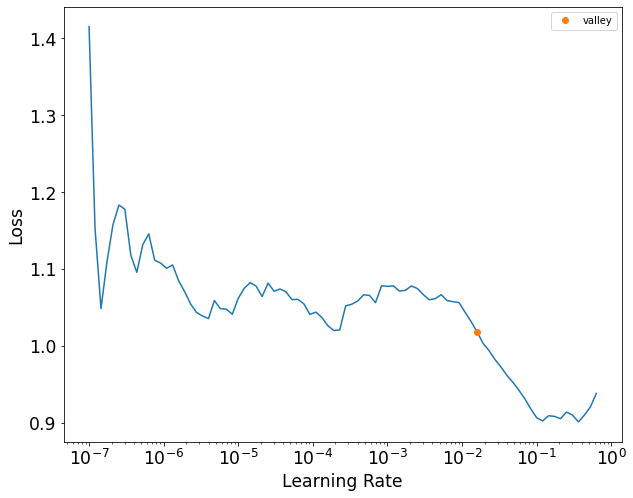

In [74]:
suggested_lr = learn.lr_find()
suggested_lr

### Training

In [75]:
learn.fit_one_cycle(epochs_max, lr_max=suggested_lr.valley)

epoch,train_loss,valid_loss,time
0,0.952616,0.716246,00:00
1,0.623235,0.341137,00:00
2,0.460872,0.317283,00:00
3,0.383326,0.315230,00:00
4,0.347163,0.298944,00:00
5,0.320433,0.286585,00:00
6,0.303074,0.279390,00:00
7,0.287768,0.278947,00:00
8,0.278835,0.278753,00:00
9,0.272542,0.274232,00:00


In [76]:
# learn.val_preds, learn.val_targets #

vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\dae_training


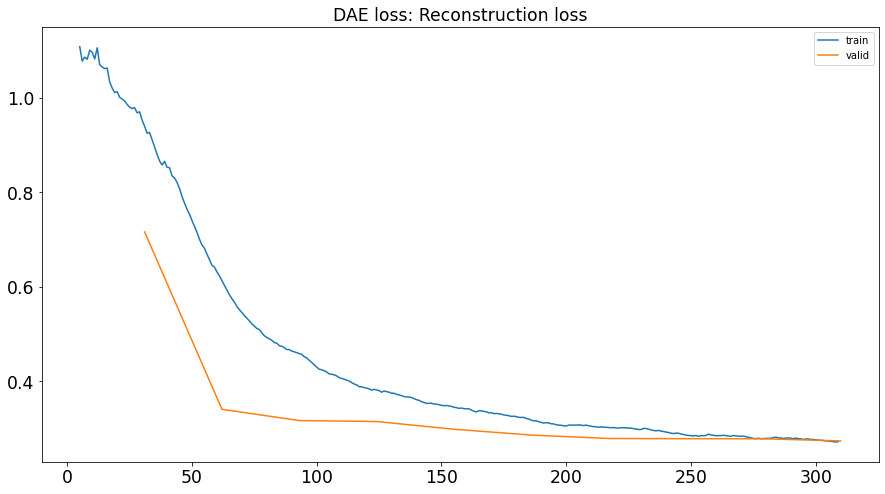

In [77]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.set_title('DAE loss: Reconstruction loss')
learn.recorder.plot_loss(skip_start=5, ax=ax)
vaep.io_images._savefig(fig, name='dae_training',
                        folder=folder)

In [78]:
# L(zip(learn.recorder.iters, learn.recorder.values))


### Evaluation

In [79]:
# reorder True: Only 500 predictions returned
pred, target = learn.get_preds(act=noop, concat_dim=0, reorder=False)
len(pred), len(target)

(4918, 4918)

MSE on transformed data is not too interesting for comparision between models if these use different standardizations

In [80]:
learn.loss_func(pred, target)  # MSE in transformed space not too interesting

TensorBase(0.2765)

In [81]:
# check target is in expected order
Y = dls.valid.targ

npt.assert_almost_equal(
    actual=target.numpy(),
    desired=Y.stack().to_numpy()
)

In [82]:
# import torch
# from fastai.tabular.core import TabularPandas

df_pred['intensity_pred_dae'] = ae.transform_preds(
    pred=pred, index=analysis.df_valid.stack().index, normalizer=tf_norm)
df_pred

intensity  \
Sample ID                           peptide                        
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 AAYLQETGKPLDETLK      28.703   
                                    AVFVDLEPTVIDEVR       32.479   
                                    EDQTEYLEER            30.817   
                                    SLHDAIMIVR            27.467   
                                    VACIGAWHPAR           28.940   
...                                                          ...   
20190805_QE1_nLC2_AB_MNT_HELA_04    DILLRPELEELR          27.801   
                                    DYGNSPLHR             28.299   
                                    IITLTGPTNAIFK         29.647   
                                    LFIGGLNTETNEK         29.555   
                                    SPYTVTVGQACNPSACR     28.526   

                                                       train_median  \
Sample ID                           peptide                           
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 AAYLQETGKPLDETLK         28.909   
                                    AVFVDLEPTVIDEVR          32.781   
                                    EDQTEYLEER               31.696   
                                    SLHDAIMIVR               28.452   
                                    VACIGAWHPAR              30.359   
...                                                             ...   
20190805_QE1_nLC2_AB_MNT_HELA_04    DILLRPELEELR             27.788   
                                    DYGNSPLHR                28.399   
                                    IITLTGPTNAIFK            29.899   
                                    LFIGGLNTETNEK            29.769   
                                    SPYTVTVGQACNPSACR        28.393   

                                                       train_average  \
Sample ID                           peptide                            
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 AAYLQETGKPLDETLK          29.133   
                                    AVFVDLEPTVIDEVR           32.496   
                                    EDQTEYLEER                31.780   
                                    SLHDAIMIVR                28.578   
                                    VACIGAWHPAR               30.262   
...                                                              ...   
20190805_QE1_nLC2_AB_MNT_HELA_04    DILLRPELEELR              27.747   
                                    DYGNSPLHR                 28.869   
                                    IITLTGPTNAIFK             30.090   
                                    LFIGGLNTETNEK             29.673   
                                    SPYTVTVGQACNPSACR         28.237   

                                                       replicates  \
Sample ID                           peptide                         
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 AAYLQETGKPLDETLK       28.444   
                                    AVFVDLEPTVIDEVR        32.449   
                                    EDQTEYLEER             31.238   
                                    SLHDAIMIVR             27.372   
                                    VACIGAWHPAR            29.478   
...                                                           ...   
20190805_QE1_nLC2_AB_MNT_HELA_04    DILLRPELEELR           28.212   
                                    DYGNSPLHR              28.484   
                                    IITLTGPTNAIFK          29.786   
                                    LFIGGLNTETNEK          29.663   
                                    SPYTVTVGQACNPSACR      28.659   

                                                       intensity_pred_collab  \
Sample ID                           peptide                                    
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 AAYLQETGKPLDETLK                  28.277   
                                    AVFVDLEPTVIDEVR                   31.831   
                                    EDQTEYLEER                        30.927   
           

### 2D plot of latent space

- 2 dimensional latent space: just plot
- more than 2 dimensional: PCA, etc

In [83]:
latent_space = []
for b in dls.valid:
    model_input = b[1]
    latent_space.append(model.encoder(model_input).detach().numpy())

df_dae_latent = build_df_from_pred_batches(latent_space,
                                           index=_df_valid.items.index,
                                           columns=[f'latent dimension {i+1}' for i in range(latent_dim)])
df_dae_latent.head()

,latent dimension 1,latent dimension 2
Sample ID,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,-0.879,0.626
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,-0.850,0.576
20181221_QE8_nLC0_NHS_MNT_HeLa_01,-0.847,0.843
20181222_QE9_nLC9_QC_50CM_HeLa1,-0.789,0.682
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,-0.824,0.812


vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\dae_latent_by_date


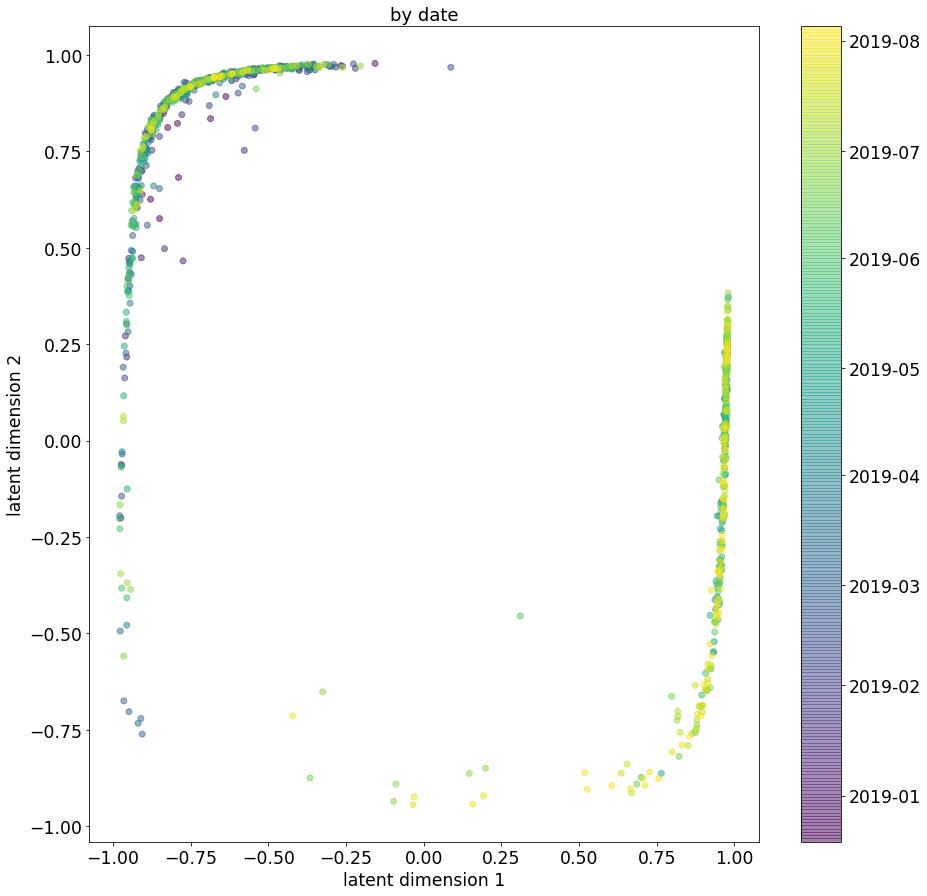

In [84]:
fig, ax = plt.subplots(figsize=(15, 15))
analyzers.plot_date_map(df=df_dae_latent, fig=fig, ax=ax,
                        dates=analysis.df_meta.date.loc[df_dae_latent.index])
vaep.io_images._savefig(fig, name='dae_latent_by_date',
                        folder=folder)

vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\dae_latent_by_ms_instrument


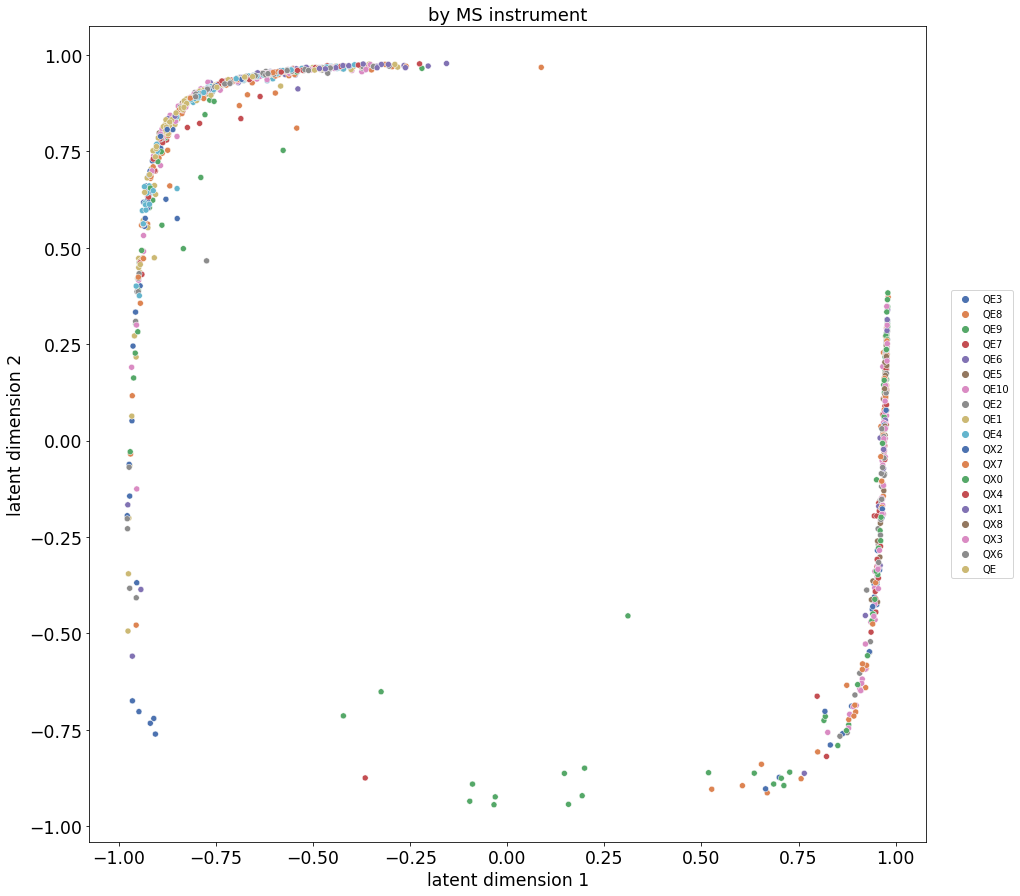

In [85]:
fig, ax = plt.subplots(figsize=(15, 15))

meta_col = 'ms_instrument'

analyzers.seaborn_scatter(df=df_dae_latent,
                          fig=fig,
                          ax=ax,
                          meta=analysis.df_meta[meta_col].loc[df_dae_latent.index],
                          title='by MS instrument')

vaep.io_images._savefig(
    fig, name=f'dae_latent_by_{meta_col}', folder=folder)

## Variational Autoencoder (VAE)

### Scikit Learn MinMaxScaler

- [docs](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [86]:
from vaep.transform import MinMaxScaler

args_vae = {}
args_vae['SCALER'] = MinMaxScaler
# select initial data: transformed vs not log transformed
scaler = args_vae['SCALER']().fit(analysis.df_train)
scaler.transform(analysis.df_valid.iloc[:5])

peptide,AAYLQETGKPLDETLK,AGVNTVTTLVENKK,ALDTMNFDVIK,AVAQALEVIPR,AVFVDLEPTVIDEVR,AVLVDLEPGTMDSVR,DILLRPELEELR,DNSTMGYMMAK,DSIVHQAGMLK,DYGNSPLHR,...,TAVETAVLLLR,TELEDTLDSTAAQQELR,TFCQLILDPIFK,TFVNITPAEVGVLVGK,TISHVIIGLK,TLGILGLGR,TNQELQEINR,VACIGAWHPAR,VLGTSVESIMATEDR,YDDMATCMK
Sample ID,,,,,,,,,,,,,,,,,,,,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,0.596,NaN,NaN,NaN,0.743,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.537,NaN,NaN
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,NaN,0.603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.660,NaN,NaN,NaN
20181221_QE8_nLC0_NHS_MNT_HeLa_01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181222_QE9_nLC9_QC_50CM_HeLa1,NaN,NaN,NaN,0.567,0.672,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.702,NaN,NaN,NaN,NaN,NaN,0.580
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,NaN,NaN,NaN,NaN,0.879,0.650,NaN,NaN,0.514,NaN,...,NaN,0.710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### DataLoaders

- follow instructions for using plain PyTorch Datasets, see [tutorial](https://docs.fast.ai/tutorial.siamese.html#Preparing-the-data)


In [87]:
assert all(analysis.df_train.columns == analysis.df_valid.columns)
if not all(analysis.df.columns == analysis.df_train.columns):
    print("analysis.df columns are not the same as analysis.df_train")
    # ToDo: DataLoading has to be cleaned up
    # analysis.df = analysis.df_train.fillna(analysis.df_valid)

analysis.df columns are not the same as analysis.df_train


In [88]:
from vaep.io.datasets import PeptideDatasetInMemory

FILL_NA = 0.0

train_ds = PeptideDatasetInMemory(data=scaler.transform(
    analysis.df_train).to_numpy(dtype=None), fill_na=FILL_NA)
valid_ds = PeptideDatasetInMemory(data=scaler.transform(analysis.df_train.fillna(analysis.df_valid)).to_numpy(dtype=None),
                                  mask=analysis.df_valid.notna().to_numpy(), fill_na=FILL_NA)

assert (train_ds.peptides == valid_ds.peptides).all()

In [89]:
dls = DataLoaders.from_dsets(train_ds, valid_ds, n_inp=2)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


### Model

In [90]:
from torch.nn import Sigmoid

M = analysis.df_train.shape[-1]
model = ae.VAE(n_features=M, n_neurons=int(
    M/2), last_encoder_activation=None, last_decoder_activation=Sigmoid, dim_latent=latent_dim)

### Learner

In [91]:
learn = Learner(dls=dls,
                model=model,
                loss_func=ae.loss_fct_vae,
                cbs=ae.ModelAdapterVAE())

learn.show_training_loop()
learn.summary()

Start Fit
   - before_fit     : [TrainEvalCallback, Recorder, ProgressCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : [ModelAdapterVAE]
         - after_pred     : [ModelAdapterVAE]
         - after_loss     : []
         - before_backward: []
         - before_step    : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]
     - after_validate : [Recorder, ProgressCallback

VAE (Input shape: 64 x 50)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 25             
Linear                                    75         True      
Tanh                                                           
____________________________________________________________________________
                     64 x 50             
Linear                                    1300       True      
Sigmoid                                                        
____________________________________________________________________________
                     64 x 25             
Linear                                    1275       True      
Tanh                                                           
____________________________________________________________________________
                     64 x 4              
Linear                                    104        True      
______________________________________________________________

### Training

SuggestedLRs(valley=0.00363078061491251)

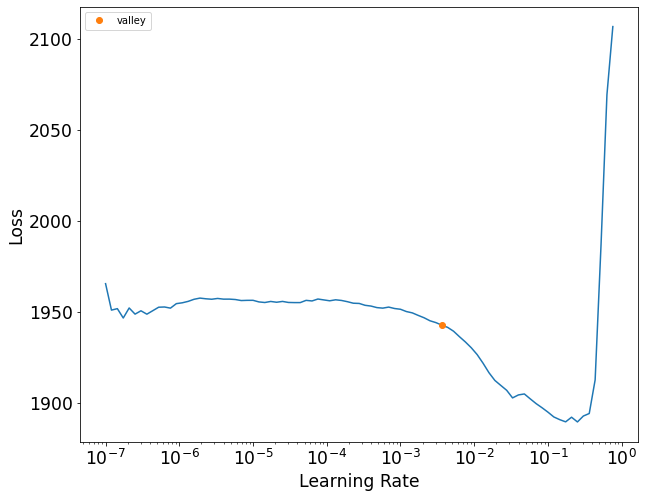

In [92]:
suggested_lr = learn.lr_find()
suggested_lr

In [93]:
learn.fit_one_cycle(epochs_max, lr_max=suggested_lr.valley)

epoch,train_loss,valid_loss,time
0,1945.383545,213.703842,00:00
1,1911.575806,203.301544,00:00
2,1857.726562,196.853546,00:00
3,1819.366455,194.975327,00:00
4,1795.157104,194.758865,00:00
5,1778.124878,196.234421,00:00
6,1767.396240,196.446121,00:00
7,1759.447632,196.550201,00:00
8,1754.679932,196.787064,00:00
9,1750.562622,196.790955,00:00


vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\vae_training


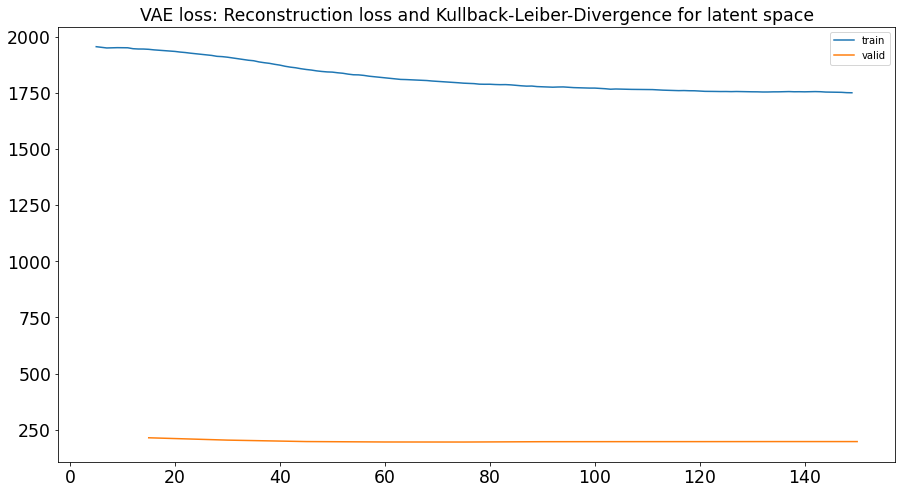

In [94]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.set_title('VAE loss: Reconstruction loss and Kullback-Leiber-Divergence for latent space')
learn.recorder.plot_loss(skip_start=5, ax=ax)
vaep.io_images._savefig(fig, name='vae_training',
                        folder=folder)

### Evaluation

In [95]:
# reorder True: Only 500 predictions returned
pred, target = learn.get_preds(act=noop, concat_dim=0, reorder=False)
len(pred), len(target)

(3, 4918)

In [96]:
len(pred[0])

4918

In [97]:
learn.loss_func(pred, target)

tensor(3106.3735)

In [98]:
_pred = pd.Series(pred[0], index=analysis.df_valid.stack().index).unstack()
_pred = scaler.inverse_transform(_pred).stack()

df_pred['intensity_pred_vae'] = _pred
df_pred

intensity  \
Sample ID                           peptide                        
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 AAYLQETGKPLDETLK      28.703   
                                    AVFVDLEPTVIDEVR       32.479   
                                    EDQTEYLEER            30.817   
                                    SLHDAIMIVR            27.467   
                                    VACIGAWHPAR           28.940   
...                                                          ...   
20190805_QE1_nLC2_AB_MNT_HELA_04    DILLRPELEELR          27.801   
                                    DYGNSPLHR             28.299   
                                    IITLTGPTNAIFK         29.647   
                                    LFIGGLNTETNEK         29.555   
                                    SPYTVTVGQACNPSACR     28.526   

                                                       train_median  \
Sample ID                           peptide                           
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 AAYLQETGKPLDETLK         28.909   
                                    AVFVDLEPTVIDEVR          32.781   
                                    EDQTEYLEER               31.696   
                                    SLHDAIMIVR               28.452   
                                    VACIGAWHPAR              30.359   
...                                                             ...   
20190805_QE1_nLC2_AB_MNT_HELA_04    DILLRPELEELR             27.788   
                                    DYGNSPLHR                28.399   
                                    IITLTGPTNAIFK            29.899   
                                    LFIGGLNTETNEK            29.769   
                                    SPYTVTVGQACNPSACR        28.393   

                                                       train_average  \
Sample ID                           peptide                            
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 AAYLQETGKPLDETLK          29.133   
                                    AVFVDLEPTVIDEVR           32.496   
                                    EDQTEYLEER                31.780   
                                    SLHDAIMIVR                28.578   
                                    VACIGAWHPAR               30.262   
...                                                              ...   
20190805_QE1_nLC2_AB_MNT_HELA_04    DILLRPELEELR              27.747   
                                    DYGNSPLHR                 28.869   
                                    IITLTGPTNAIFK             30.090   
                                    LFIGGLNTETNEK             29.673   
                                    SPYTVTVGQACNPSACR         28.237   

                                                       replicates  \
Sample ID                           peptide                         
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 AAYLQETGKPLDETLK       28.444   
                                    AVFVDLEPTVIDEVR        32.449   
                                    EDQTEYLEER             31.238   
                                    SLHDAIMIVR             27.372   
                                    VACIGAWHPAR            29.478   
...                                                           ...   
20190805_QE1_nLC2_AB_MNT_HELA_04    DILLRPELEELR           28.212   
                                    DYGNSPLHR              28.484   
                                    IITLTGPTNAIFK          29.786   
                                    LFIGGLNTETNEK          29.663   
                                    SPYTVTVGQACNPSACR      28.659   

                                                       intensity_pred_collab  \
Sample ID                           peptide                                    
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 AAYLQETGKPLDETLK                  28.277   
                                    AVFVDLEPTVIDEVR                   31.831   
                                    EDQTEYLEER                        30.927   
           

### Add plot of latent space

- 2 dimensional latent space: just plot
- more than 2 dimensional: PCA, etc

In [99]:
latent_space = []
for b in dls.valid:
    model_input = b[0]
    b_mu, b_std = model.get_mu_and_logvar(model_input, detach=True)
    latent_space.append(b_mu)


df_vae_latent = build_df_from_pred_batches(latent_space,
                                           index=_df_valid.items.index,
                                           columns=[f'latent dimension {i+1}' for i in range(latent_dim)])
df_vae_latent.head()

,latent dimension 1,latent dimension 2
Sample ID,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,-0.025,-0.094
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,-0.102,-0.154
20181221_QE8_nLC0_NHS_MNT_HeLa_01,-0.197,-0.257
20181222_QE9_nLC9_QC_50CM_HeLa1,-0.047,-0.093
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,-0.002,0.014


vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\vae_latent_by_date


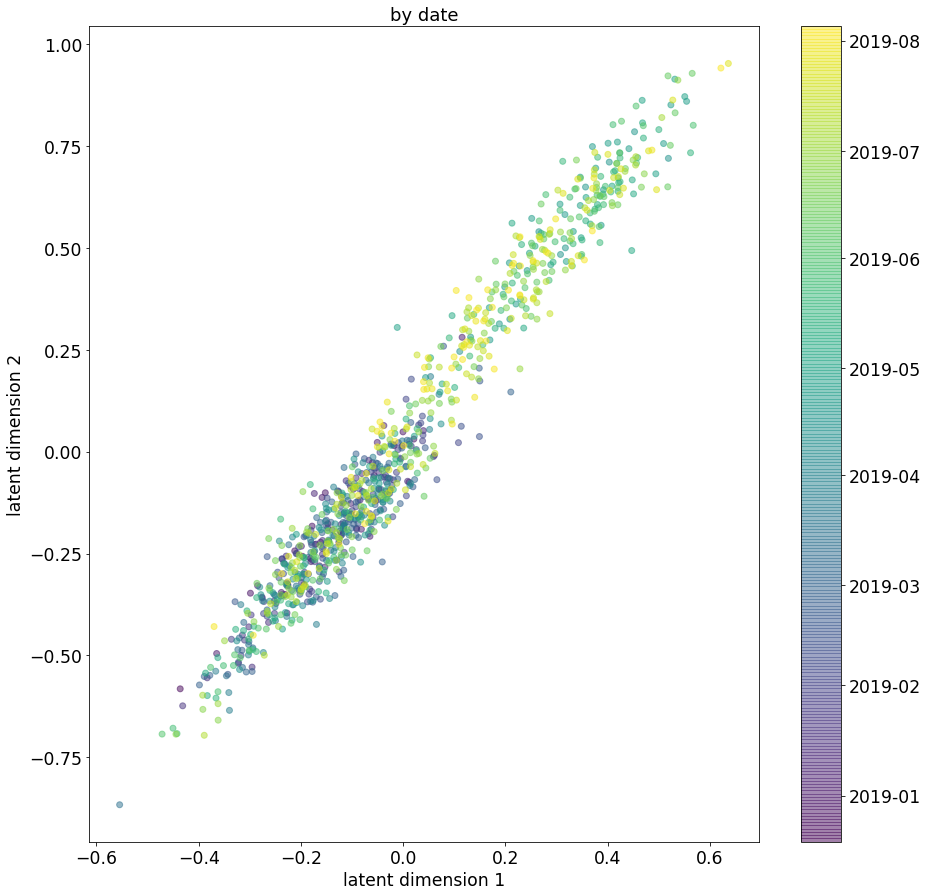

In [100]:
fig, ax = plt.subplots(figsize=(15, 15))
analyzers.plot_date_map(df=df_vae_latent, fig=fig, ax=ax,
                        dates=analysis.df_meta.date.loc[df_vae_latent.index])
vaep.io_images._savefig(fig, name='vae_latent_by_date',
                        folder=folder)

vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\vae_latent_by_ms_instrument


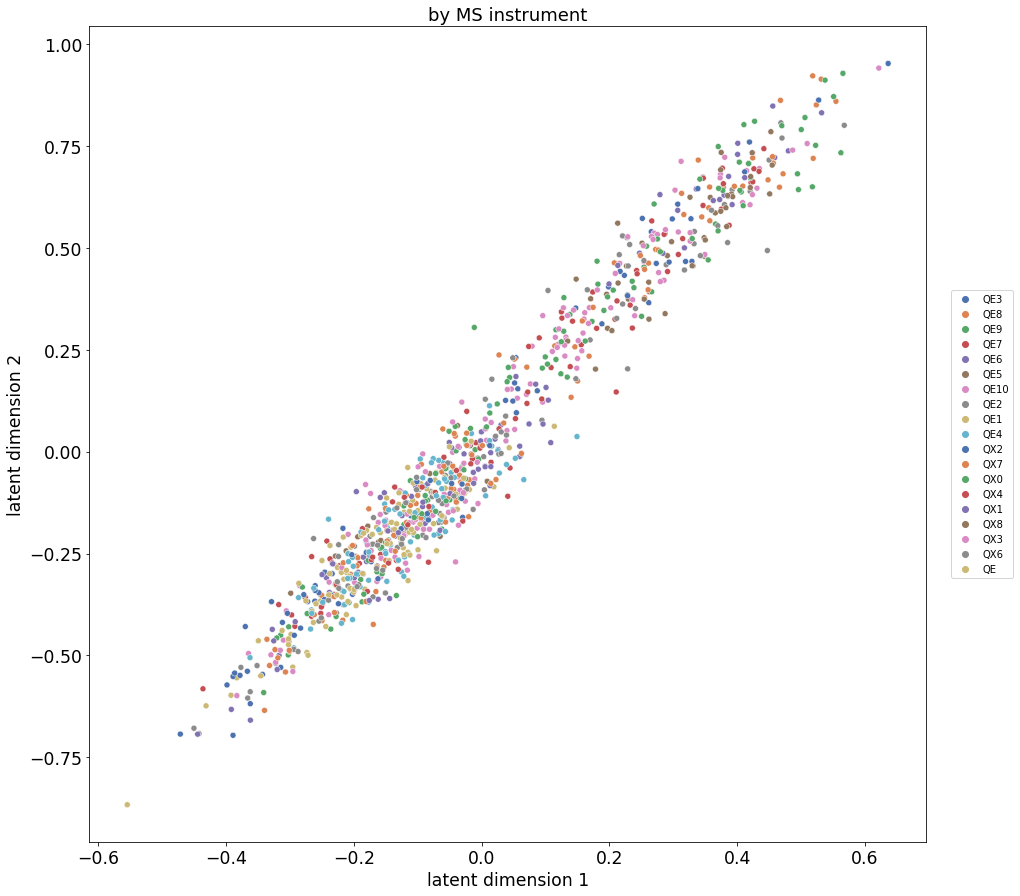

In [101]:
fig, ax = plt.subplots(figsize=(15, 15))

meta_col = 'ms_instrument'

analyzers.seaborn_scatter(df=df_vae_latent,
                          fig=fig,
                          ax=ax,
                          meta=analysis.df_meta[meta_col].loc[df_vae_latent.index],
                          title='by MS instrument')

vaep.io_images._savefig(
    fig, name=f'vae_latent_by_{meta_col}', folder=folder)

## Compare the 3 models

- replicates: replace NAs with neighbouring ("close") values
- train average, median: Replace NA with average or median from training data

In [102]:
import sklearn.metrics as sklm
pred_columns = df_pred.columns[1:]
scoring = [('MSE', sklm.mean_squared_error),
           ('MAE', sklm.mean_absolute_error)]

y_true = df_pred['intensity']

metrics = {}
for col in pred_columns:
    _y_pred = df_pred[col].dropna()
    if len(df_pred[col]) > len(_y_pred):
        logger.info(
            f"Drop indices for {col}: {[(idx[0], idx[1]) for idx in df_pred[col].index.difference(_y_pred.index)]}")

    metrics[col] = dict(
        [(k, f(y_true=y_true.loc[_y_pred.index], y_pred=_y_pred))
         for k, f in scoring]
    )

metrics = pd.DataFrame(metrics)
metrics.to_csv(folder / f'exp_02_metrics.csv',
               float_format='{:.3f}'.format)
metrics.sort_values(by=[k for k, f in scoring], axis=1)

vaep - INFO     Drop indices for replicates: [('20181229_QE5_nLC5_OOE_QC_MNT_HELA_15cm_250ng_RO-052', 'ILLAELEQLK'), ('20181229_QE5_nLC5_OOE_QC_MNT_HELA_15cm_250ng_RO-052', 'SLAGSSGPGASSGTSGDHGELVVR'), ('20181229_QE5_nLC5_OOE_QC_MNT_HELA_15cm_250ng_RO-053', 'ILLAELEQLK'), ('20190107_QE5_nLC5_DS_QC_MNT_HeLa_FlashPack_03', 'IITLTGPTNAIFK'), ('20190108_QE1_nLC2_MB_QC_MNT_HELA_old_01', 'DYGNSPLHR'), ('20190118_QE1_nLC2_ANHO_QC_MNT_HELA_03', 'KYEDICPSTHNMDVPNIK'), ('20190118_QE9_nLC9_NHS_MNT_HELA_50cm_03', 'KYEDICPSTHNMDVPNIK'), ('20190121_QE4_LC6_IAH_QC_MNT_HeLa_250ng_02', 'SLHDAIMIVR'), ('20190121_QE4_LC6_IAH_QC_MNT_HeLa_250ng_03', 'SLHDAIMIVR'), ('20190129_QE10_nLC0_FM_QC_MNT_HeLa_50cm_01', 'GHFGPINSVAFHPDGK'), ('20190201_QE1_nLC2_GP_QC_MNT_HELA_01', 'HLAGLGLTEAIDK'), ('20190204_QE6_nLC6_MPL_QC_MNT_HeLa_04', 'GIPHLVTHDAR'), ('20190206_QE8_nLC0_ASD_QC_HeLa_50cm_20190206192638', 'LSFQHDPETSVLVLR'), ('20190207_QE8_nLC0_ASD_QC_HeLa_43cm3', 'GHFGPINSVAFHPDGK'), ('20190207_QE8_nLC0_ASD_QC_HeLa

,intensity_pred_collab,intensity_pred_dae,replicates,intensity_pred_vae,train_average,train_median
MSE,0.467,0.489,1.405,1.551,1.798,1.877
MAE,0.421,0.440,0.820,0.918,0.999,0.978


Save final prediction values of validation data for later comparison.

In [103]:
df_pred.to_csv(folder /
               f"{config.FOLDER_DATA}_valid_pred.csv")

## PCA plot for imputed and denoised data

two setups:
 - impute missing values
 - additinally change observed values